In [16]:
import os.path
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import lines
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch

from astropy import units as u
import astropy.table
from astropy.table import Table
import pandas as pd

import scipy
import scipy.stats as st

from tqdm import tqdm
from timeit import default_timer as timer

import galpy
from galpy.util.coords import galcenrect_to_XYZ, XYZ_to_lbd, lb_to_radec

#import src.gesp.utils_star_sample_public
from src.modules import utils_star_sample_public as UTILS
from src.modules import occ_rates_fcts as OCCRATE_MODULE
from src.modules import exoplanet_parameters_fcts as EXOPL_MODULE
from src.modules import detectability_fcts as DETECTION_MODULE

import importlib

import seaborn as sb
import random
import scienceplots
plt.style.use(['science', 'no-latex'])

In [2]:
#! pip install SciencePlots

# Fig.1: SN selection in g7.55e11 + age-metallicity distribution

In [23]:
g755 = Table.read("./data/plots_files/7.55e11.01024_stars_rsphmax25.0_newcoords.parquet")
sp = Table.read("./data/plots_files/sp_SN_g755e11.fits").to_pandas()

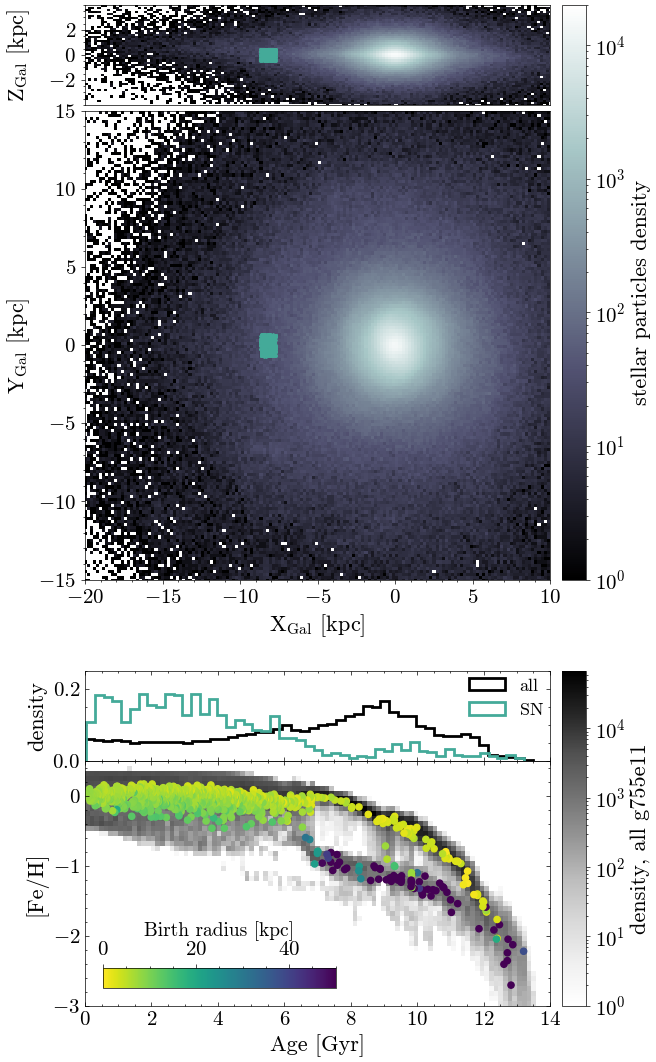

In [24]:
fig, (ax, axb) = plt.subplots(2, 1, figsize=(6, 13.0), gridspec_kw={'height_ratios':[0.6, 0.35]})

fs = 16

vmin_dens = 1
vmax_dens = 20000

divider = make_axes_locatable(ax)
axtop = divider.append_axes('top', 1.0, sharex=ax, pad=0.06)
axtop.xaxis.set_visible(False)

[[x10,y10],[x11,y11]] = ax.get_position().get_points()
[[x10t,y10t],[x11t,y11t]] = axtop.get_position().get_points()

c1 = ax.hist2d(g755["x_gal"][(abs(g755['z']) < 0.5)], g755["y_gal"][(abs(g755['z']) < 0.5)], 
           bins=(250, 250), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

axtop.hist2d(g755["x_gal"][(abs(g755['y_gal']) < 0.5)], g755["z"][(abs(g755['y_gal']) < 0.5)], 
           bins=(250, 50), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

axtop.set_ylabel(r"$\rm Z_{\rm Gal}$ [kpc]", labelpad=12, fontsize=fs)
axtop.set_xlim([-20, 10])
axtop.set_ylim([-4, 4])
axtop.set_yticks([-2, 0, 2])
axtop.tick_params(axis='x', labelsize=fs-1, direction='out', which='both')
axtop.tick_params(axis='y', labelsize=fs-1, direction='out', which='both', right=False)
axtop.scatter(sp["x_gal"], sp["z"], s=1, c='#44AA99', rasterized=True)

ax.scatter(sp["x_gal"], sp["y_gal"], s=1, c='#44AA99', rasterized=True)
ax.set_xlim([-20, 10])
ax.set_ylim([-15, 15])
ax.set_xlabel(r"$\rm X_{\rm Gal}$ [kpc]", fontsize=fs)
ax.set_ylabel(r"$\rm Y_{\rm Gal}$ [kpc]", fontsize=fs)
ax.tick_params(axis='x', labelsize=fs-1, direction='out', which='both', top=False)
ax.tick_params(axis='y', labelsize=fs-1, direction='out', which='both', right=False)

cbar_ax = fig.add_axes([x11+0.02, y10, 0.04, y11t-y10])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(c1[3], cax=cbar_ax)
cbar.set_label('stellar particles density', fontsize=fs)
cbar_ax.tick_params(labelsize=fs-1, direction='out', which='both')

##########

dividerb = make_axes_locatable(axb)
axtopb = dividerb.append_axes('top', 0.9, sharex=axb, pad=0)
# the entire galaxy
c_all = axb.hist2d(g755["age"], g755["feh"], bins=(np.linspace(0, 14, 100), np.linspace(-3, 0.5, 50)), 
           cmap='Greys', norm=colors.LogNorm(), rasterized=True)

# the SN selection
c1b = axb.scatter(sp["age"], sp["feh"],c=sp["rbirth"], vmin=0, vmax=50, s=20, cmap='viridis_r', rasterized=False)#, cmap='Wistia')
axb.set_xlim([0, 14])
axb.set_ylim([-3, 0.5])

###### colorbar inside plot (R_birth)
[[xbl,ybl],[xtr,ytr]] = axb.get_position().get_points()
cbarb2_ax = fig.add_axes([xbl+0.03, ybl+0.014, (xtr-xbl)/2, 0.015])
cbarb2 = fig.colorbar(c1b, cax=cbarb2_ax, orientation='horizontal')
cbarb2_ax.xaxis.set_ticks_position('top')
cbarb2_ax.xaxis.set_label_position('top')
cbarb2.set_label("Birth radius [kpc]", fontsize=fs-2)
cbarb2_ax.tick_params(labelsize=fs-1, direction='out', which='both')

##### colorbar on the side (density all simu)
[[xbl,ybl],[xtr,ytr]] = axb.get_position().get_points()
cbarb_ax = fig.add_axes([xtr+0.02, ybl, 0.04, ytr-ybl])
cbarb_ax.yaxis.set_ticks_position('right')
cbarb = fig.colorbar(c_all[3], cax=cbarb_ax)
cbarb.set_label("density, all g755e11", fontsize=fs)
cbarb_ax.tick_params(labelsize=fs-1, direction='out', which='both')

### add age histograms
axtopb.hist(g755["age"], bins=50, histtype='step', lw=2, color='k', density=True, label='all', rasterized=True)
axtopb.hist(sp["age"], bins=50, histtype='step', lw=2, color='#44AA99', density=True, label='SN', rasterized=True)

#axtopb.set_xticklabels([])
plt.setp(axtopb.get_xticklabels(), visible=False)
axtopb.legend(loc='upper right', bbox_to_anchor=(1.02, 1.1), fontsize=fs-3, frameon=False)
axtopb.tick_params(axis='y', labelsize=fs-1)
axtopb.set_ylabel("density", fontsize=fs)
axtopb.set_ylim((0, 0.25))

axb.set_xlabel("Age [Gyr]", fontsize=fs)
axb.set_ylabel("[Fe/H]", fontsize=fs)
axb.set_yticks([-3, -2, -1, 0])
axb.tick_params(axis='x', labelsize=fs-1)
axb.tick_params(axis='y', labelsize=fs-1)

#plt.savefig("figures/SN_selection_XY-Zplot_14juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig.2: Occ. rate and multiplicity

In [2]:
c_earth = "#251FC1"
c_SEn = "#B865AF"
c_giants = "#F17604"

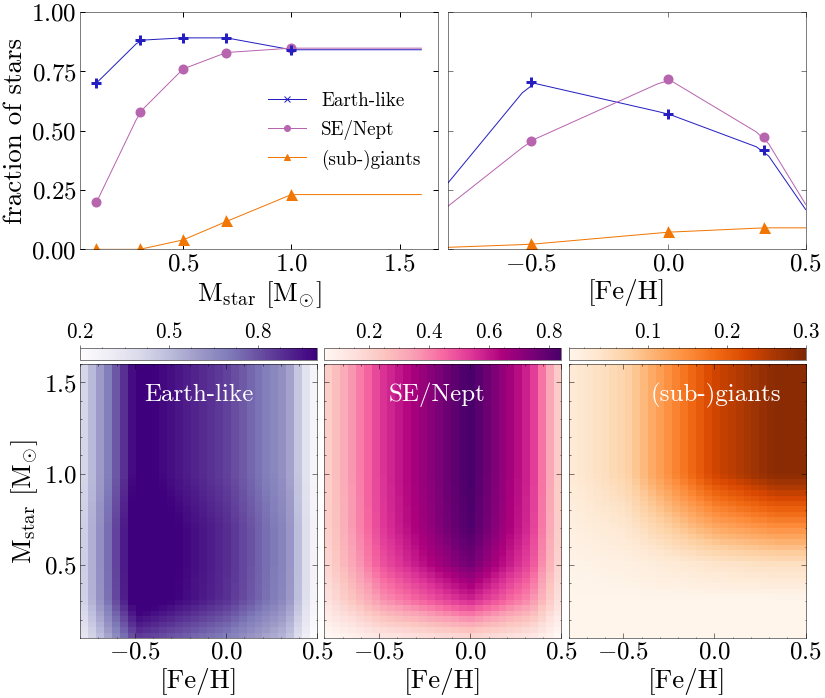

In [ ]:
fs = 27

m = np.linspace(0.1, 1.6, 50)
stellar_feh = np.array([-0.5, 0, 0.35])
feh_range = np.linspace(-0.8, 0.5, 30)

fig = plt.figure(figsize=(13, 10))

gs1 = fig.add_gridspec(nrows=1, ncols=2, top=0.98, bottom=0.65, wspace=0.03)
ax1 = fig.add_subplot(gs1[:,0])
ax2 = fig.add_subplot(gs1[:,1], sharey=ax1)

gs2 = fig.add_gridspec(nrows=1, ncols=3, top=0.58, bottom=0.02, wspace=0.03)
ax3 = fig.add_subplot(gs2[:,0])
ax4 = fig.add_subplot(gs2[:,1], sharey=ax3, sharex=ax3)
ax5 = fig.add_subplot(gs2[:,2], sharey=ax3, sharex=ax3)

ax1.plot(OCCRATE_MODULE.stellar_masses_Burn21, OCCRATE_MODULE.fraction_stars_with_earthlike, '+', ms=10, mew=3, c=c_earth, zorder=5)
ax1.plot(OCCRATE_MODULE.stellar_masses_Burn21, OCCRATE_MODULE.fraction_stars_with_superearth_nept, 'o', ms=7, mew=3, c=c_SEn)
ax1.plot(OCCRATE_MODULE.stellar_masses_Burn21, OCCRATE_MODULE.fraction_stars_with_giants, '^', ms=7, mew=3, c=c_giants)
ax1.plot(m, OCCRATE_MODULE.fraction_earthlike(m), c=c_earth)
ax1.plot(m, OCCRATE_MODULE.fraction_SE_nept(m), c=c_SEn)
ax1.plot(m, OCCRATE_MODULE.fraction_giants(m), c=c_giants)

ax2.plot(stellar_feh, OCCRATE_MODULE.OR_1_2_Rearth, '+', ms=10, mew=3, c=c_earth)
ax2.plot(stellar_feh, OCCRATE_MODULE.OR_2_8_Rearth, 'o', ms=7, mew=3, c=c_SEn)
ax2.plot(stellar_feh, OCCRATE_MODULE.OR_8_20_Rearth, '^', ms=7, mew=3, c=c_giants)
ax2.plot(feh_range, OCCRATE_MODULE.occ_rate_feh_Earthlike_Aboth(feh_range), c=c_earth)
ax2.plot(feh_range, OCCRATE_MODULE.occ_rate_feh_SE_nept_Aboth(feh_range), c=c_SEn)
ax2.plot(feh_range, OCCRATE_MODULE.occ_rate_feh_giants_Aleft(feh_range), c=c_giants)

cb_El = ax3.imshow(OCCRATE_MODULE.occ_rate_Earthlike_plot2d_A(feh_range, m), origin='lower', 
                  extent=[-0.8, 0.5, 0.1, 1.6], cmap='Purples', rasterized=True, vmin=0.2)#, vmax=1) #, vmax=1)
cb_SEn = ax4.imshow(OCCRATE_MODULE.occ_rate_SEnept_plot2d_A(feh_range, m), origin='lower', 
                   extent=[-0.8, 0.5, 0.1, 1.6], cmap='RdPu', rasterized=True)#, vmin=0)#, vmax=1)
cb_g = ax5.imshow(OCCRATE_MODULE.occ_rate_giants_plot2d_A(feh_range, m), origin='lower', 
                 extent=[-0.8, 0.5, 0.1, 1.6], cmap='Oranges', rasterized=True, vmax=0.3)#, vmin=0)#, vmax=1)

#cb = fig.colorbar(c_g, ax=ax5)
cbar_El = fig.colorbar(cb_El, ax=ax3, location='top', pad=0.01, ticks=[0.2, 0.5, 0.8])
cbar_SNe = fig.colorbar(cb_SEn, ax=ax4, location='top', pad=0.01, ticks=[0.2, 0.4, 0.6, 0.8])
cbar_g = fig.colorbar(cb_g, ax=ax5, location='top', pad=0.01, ticks=[0.1, 0.2, 0.3])

ax1.legend([lines.Line2D([0], [0], marker='x', ls='-', c=c_earth),
           lines.Line2D([0], [0], marker='o', ls='-', c=c_SEn),
           lines.Line2D([0], [0], marker='^', ls='-', c=c_giants)],
          ['Earth-like', 'SE/Nept', '(sub-)giants'],
          loc='center right', fontsize=fs-8)

#ax1.legend(fontsize=13)
ax1.set_ylim((0.0, 1))
ax1.set_xlabel(r'$\rm M_{\rm star}$ [M$_{\odot}$]', fontsize=fs)
ax1.set_ylabel('fraction of stars', fontsize=fs)
#ax2.set_yscale('log')
ax2.set_ylim((0.0, 1))
ax2.set_xlim((feh_range[0], feh_range[-1]))
ax2.set_xlabel('[Fe/H]', fontsize=fs)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3.set_ylabel(r'$\rm M_{\rm star}$ [M$_{\odot}$]', fontsize=fs)
ax3.set_xlabel('[Fe/H]', fontsize=fs)
ax4.set_xlabel('[Fe/H]', fontsize=fs)
ax5.set_xlabel('[Fe/H]', fontsize=fs)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)

ax1.tick_params(axis='both', which='major', labelsize=fs-2, length=5, width=1)
ax1.minorticks_off()
ax2.tick_params(axis='both', which='major', labelsize=fs-2, length=5)
ax2.minorticks_off()
ax3.tick_params(axis='both', which='major', labelsize=fs-2, length=5)
ax4.tick_params(axis='both', which='major', labelsize=fs-2, length=5)
ax5.tick_params(axis='both', which='major', labelsize=fs-2, length=5)

cbar_El.ax.tick_params(labelsize=fs-6, direction='out', which='both')
cbar_SNe.ax.tick_params(labelsize=fs-6, direction='out', which='both')
cbar_g.ax.tick_params(labelsize=fs-6, direction='out', which='both')

ax3.text(-0.45, 1.40, 'Earth-like', fontsize=fs-2, c='white')
ax4.text(-0.45, 1.40, 'SE/Nept', fontsize=fs-2, c='white')
ax5.text(-0.35, 1.40, '(sub-)giants', fontsize=fs-2, c='white')

#plt.savefig("./figures/occ_rate_mass_feh_combined_11agost25.pdf", bbox_inches='tight')
plt.show()

# Fig.3: Mass-Period distribution / fitting

In [3]:
det_pl_ONLYrad = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYrad.fits").to_pandas()
det_pl_ONLYmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYmass.fits").to_pandas()
det_pl_radANDmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_radANDmass.fits").to_pandas()

In [5]:
### import stars table for the SN
sample_SN = UTILS.PlanetSample()
sample_SN.load_previously_computed_files_PLOTS('SN_755e11', '25juliol24_rerun_3mars25_AltMet', 
                                         load_allstars=False, 
                                         load_singles=False, 
                                         load_binaries=False, 
                                         load_multiples=False, 
                                         load_planets=True, 
                                         load_singles_with_planetcols=False,
                                         path="./data/plots_files/")

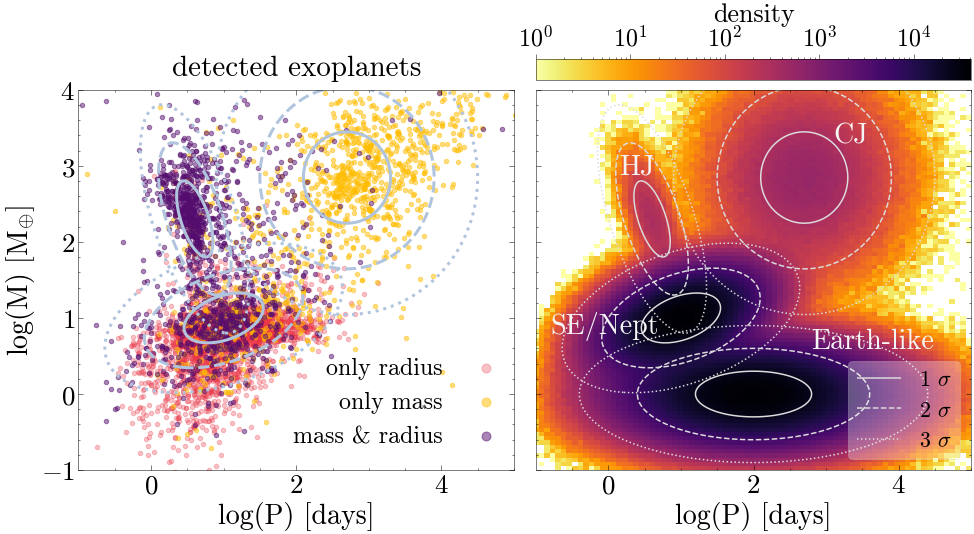

17.70836875299574


In [ ]:
fs = 28
##### only density plot

starttime = timer()

x = np.linspace(-1, 5, 500)
y = np.linspace(-1, 4, 500)
X, Y = np.meshgrid(x, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)
step = 1
step_density = 1

#### plot observed exoplanets
## plnts with radius: converted to mass
ax1.scatter(np.log10(det_pl_ONLYrad['pl_orbper']), np.log10(det_pl_ONLYrad['pl_bmasse_converted']), 
            s=20, c='#EA3546', alpha=0.3, label='only radius', rasterized=True)
## plnts with masses
ax1.scatter(np.log10(det_pl_ONLYmass['pl_orbper']), np.log10(det_pl_ONLYmass['pl_bmasse']), 
            s=20, c='#FFBD00', alpha=0.5, label='only mass', rasterized=True)
## plnts with both R and M
ax1.scatter(np.log10(det_pl_radANDmass['pl_orbper']), np.log10(det_pl_radANDmass['pl_bmasse']), 
            s=20, c="#540D6E", alpha=0.5, label='mass & radius', rasterized=True)

##### contours
for i in range(4):
    s1 = st.multivariate_normal(EXOPL_MODULE.means_logP_logM_I4G[i], EXOPL_MODULE.covs_logP_logM_I4G[i]).pdf([EXOPL_MODULE.means_logP_logM_I4G[i][0]+EXOPL_MODULE.pg[i][0], EXOPL_MODULE.means_logP_logM_I4G[i][1]])
    s2 = st.multivariate_normal(EXOPL_MODULE.means_logP_logM_I4G[i], EXOPL_MODULE.covs_logP_logM_I4G[i]).pdf([EXOPL_MODULE.means_logP_logM_I4G[i][0]+2*EXOPL_MODULE.pg[i][0], EXOPL_MODULE.means_logP_logM_I4G[i][1]])
    s3 = st.multivariate_normal(EXOPL_MODULE.means_logP_logM_I4G[i], EXOPL_MODULE.covs_logP_logM_I4G[i]).pdf([EXOPL_MODULE.means_logP_logM_I4G[i][0]+3*EXOPL_MODULE.pg[i][0], EXOPL_MODULE.means_logP_logM_I4G[i][1]])
    gaussianfit = st.multivariate_normal(EXOPL_MODULE.means_logP_logM_I4G[i], EXOPL_MODULE.covs_logP_logM_I4G[i]).pdf(np.dstack((X, Y)))
    cs2 = ax2.contour(X, Y, gaussianfit, [s3, s2, s1],
                      colors='gainsboro',
                      linestyles= ['dotted', 'dashed', 'solid'], linewidths=1.5)
    if i < 3:
        ax1.contour(X, Y, gaussianfit, [s3, s2, s1],
                      colors='lightsteelblue',
                      linestyles= ['dotted', 'dashed', 'solid'], linewidths=3)

    cslabels,_ = cs2.legend_elements()
   
c2 = ax2.hist2d(np.log10(sample_SN.planets.dropna(subset='period_planet').period_planet.values.astype(float)), np.log10(sample_SN.planets.dropna(subset='period_planet').mass_planet.values.astype(float)), 
           bins=(100, 100), cmap='inferno_r', norm=colors.LogNorm(), rasterized=True)

### add text with name of planetary categories
text_color = 'whitesmoke'
ax2.text(-0.8, 0.8, 'SE/Nept', fontsize=fs, c=text_color, fontweight='black')
ax2.text(3.1, 3.3, 'CJ', fontsize=fs, c=text_color, fontweight='black')
ax2.text(0.15, 2.9, 'HJ', fontsize=fs, c=text_color, fontweight='black')
ax2.text(2.8, 0.6, 'Earth-like', fontsize=fs, c=text_color, fontweight='black')

### colorbar on top
[[x10,y10],[x11,y11]] = ax2.get_position().get_points()
pad = 0.02; width = 0.04
cbar_ax = fig.add_axes([x10, y11+pad, (x11-x10), width])
cbar = fig.colorbar(c2[3], cax=cbar_ax, orientation='horizontal')
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
cbar_ax.tick_params(labelsize=fs-4, which='both', direction='out')
cbar_ax.tick_params(which='major', length=5)
cbar_ax.tick_params(which='minor', length=2)


cbar.set_label('density', fontsize=fs-2)

ax2.set_ylim(-1, 4)
ax2.set_xlim(-1, 5)
ax2.set_xlabel("log(P) [days]", fontsize=fs)
ax1.set_xlabel("log(P) [days]", fontsize=fs)
ax1.set_ylabel("log(M) [M$_{\oplus}$]", fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax2.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax1.tick_params(axis='both', which='minor', labelsize=fs-1, length=2)
ax2.tick_params(axis='both', which='minor', labelsize=fs-1, length=2)
ax2.legend(cslabels[::-1], ['1 $\sigma$', '2 $\sigma$', '3 $\sigma$'], loc='lower right', #ncol=3,
           fontsize=fs-6, framealpha=0.3, frameon=True)
ax1.legend(fontsize=fs-4, markerfirst=False, markerscale=2, 
           loc='lower right', bbox_to_anchor=(1.04, 0.003))
ax1.set_title("detected exoplanets", fontsize=fs+1, pad=15)

#plt.savefig("./figures/distrib_MP_planets_density_vs_obs_14juliol25_labels.pdf", bbox_inches='tight')
plt.show()

print(timer()-starttime)

# Fig.4: Influence of the planet type definition on exoplanets yields

In [7]:
### import stars table for the SN
sample_SN = UTILS.PlanetSample()
sample_SN.load_previously_computed_files_PLOTS('SN_755e11', '25juliol24_rerun_3mars25_AltMet', 
                                         load_allstars=False, 
                                         load_singles=False, 
                                         load_binaries=False, 
                                         load_multiples=False, 
                                         load_planets=True, 
                                         load_singles_with_planetcols=True)

In [11]:
limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

# Values of each group
bars_EL = []
bars_SE = []
bars_G = []
EL_perc = []
SE_perc = []
G_perc = []

labels_samples = ['simu (labels)', 'simu (mass)', 'simu (radius)']

#### pl_detect, assigned types
nb_tot_pl = len(sample_SN.planets)
nb_hs_simu = len(sample_SN.singles[(sample_SN.singles['have_Earthlike']==True) | (sample_SN.singles['have_SE_nept']==True) | (sample_SN.singles['have_Earthlike']==True)])
bars_EL.append(len(sample_SN.planets[sample_SN.planets['planet_type']=='Earthlike'])/nb_hs_simu)
bars_SE.append(len(sample_SN.planets[sample_SN.planets['planet_type']=='SE_nept'])/nb_hs_simu)
bars_G.append(len(sample_SN.planets[sample_SN.planets['planet_type']=='giant'])/nb_hs_simu)
EL_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['planet_type']=='Earthlike'])/nb_tot_pl*100, 1))+'%')
SE_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['planet_type']=='SE_nept'])/nb_tot_pl*100, 1))+'%')
G_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['planet_type']=='giant'])/nb_tot_pl*100, 1))+'%')

#### pl_detect, mass based types
bars_EL.append(len(sample_SN.planets[sample_SN.planets['mass_planet']<limM_Earth_to_SEnept])/nb_hs_simu)
bars_SE.append(len(sample_SN.planets[(sample_SN.planets['mass_planet']>=limM_Earth_to_SEnept) & (sample_SN.planets['mass_planet']<limM_SEnept_to_giants)])/nb_hs_simu)
bars_G.append(len(sample_SN.planets[sample_SN.planets['mass_planet']>=limM_SEnept_to_giants])/nb_hs_simu)
EL_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['mass_planet']<limM_Earth_to_SEnept])/nb_tot_pl*100, 1))+'%')
SE_perc.append(str(np.round(len(sample_SN.planets[(sample_SN.planets['mass_planet']>=limM_Earth_to_SEnept) & (sample_SN.planets['mass_planet']<limM_SEnept_to_giants)])/nb_tot_pl*100, 1))+'%')
G_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['mass_planet']>=limM_SEnept_to_giants])/nb_tot_pl*100, 1))+'%')

#### pl_detect, radius based types
bars_EL.append(len(sample_SN.planets[sample_SN.planets['radius_planet']<limR_Earth_to_SEnept])/nb_hs_simu)
bars_SE.append(len(sample_SN.planets[(sample_SN.planets['radius_planet']>=limR_Earth_to_SEnept) & (sample_SN.planets['radius_planet']<limR_SEnept_to_giants)])/nb_hs_simu)
bars_G.append(len(sample_SN.planets[sample_SN.planets['radius_planet']>=limR_SEnept_to_giants])/nb_hs_simu)
EL_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['radius_planet']<limR_Earth_to_SEnept])/nb_tot_pl*100, 1))+'%')
SE_perc.append(str(np.round(len(sample_SN.planets[(sample_SN.planets['radius_planet']>=limR_Earth_to_SEnept) & (sample_SN.planets['radius_planet']<limR_SEnept_to_giants)])/nb_tot_pl*100, 1))+'%')
G_perc.append(str(np.round(len(sample_SN.planets[sample_SN.planets['radius_planet']>=limR_SEnept_to_giants])/nb_tot_pl*100, 1))+'%')

# Heights of bars1 + bars2
bars = np.add(bars_EL, bars_SE).tolist()
 
# The position of the bars on the x-axis
r = np.arange(0, 3)
 
# Names of group and bar width
names = labels_samples
barWidth = 1

###################
category_names = ['Earth-like', 'SE/Neptunians', 'Giants']
category_colors = ['#251FC1', '#B865AF', '#F17604']
labels_def = ['labels', 'mass', 'radius']

list_labels_perc = [EL_perc, SE_perc, G_perc]

dict = {category_names[0]: bars_EL, category_names[1]: bars_SE, category_names[2]: bars_G}
df = pd.DataFrame(dict)

color_dict = {}
for i in range(len(category_names)):
    color_dict[category_names[i]] = category_colors[i]

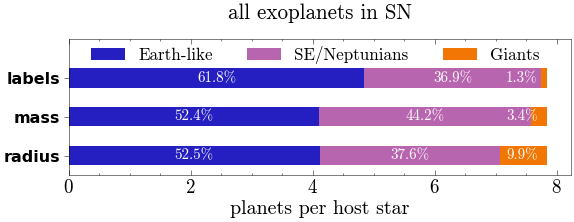

In [ ]:
fs = 20
barWidth = 1
ax = df.plot.barh(stacked=True, figsize=(9, 2.5), 
                  color=color_dict)

ax.set_yticks(r, labels_def, fontname='Arial', fontweight='bold', fontsize=fs-4)
ax.set_title("all exoplanets in SN", fontsize=fs+1, pad=20)

i=0
for c in ax.containers:
    if i != 2:
        ax.bar_label(c, labels=list_labels_perc[i], label_type='center', 
                    color='white', weight="bold", fontsize=fs-5)
    else:
        ax.bar_label(c, labels=list_labels_perc[i], label_type='edge', padding=-41,
                    color='white', weight="bold", fontsize=fs-5)
    i+=1

ax.set_xlabel('planets per host star', fontsize=fs)

ax.tick_params(axis='y', which='major', direction='out', length=5, right=False)
ax.tick_params(axis='y', which='minor', right=False, left=False)
ax.tick_params(axis='x', which='major', labelsize=fs-1, length=5)
ax.tick_params(axis='x', which='minor', length=2)
ax.invert_yaxis()
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]-0.5)

ax.legend(loc=(0.03, 0.77), fontsize=fs-3, frameon=False, ncol=3)

#plt.savefig("figures/SN_comparison_planettypes_def.png", bbox_inches='tight')
plt.show()

# Fig.5: HRd and mass-metallicity diagram for all simulated stars in the SN

In [15]:
sample_SN = UTILS.PlanetSample()
sample_SN.load_previously_computed_files_PLOTS('SN_755e11', '25juliol24_rerun_3mars25_AltMet', 
                                         load_allstars=False, 
                                         load_singles=False, 
                                         load_binaries=False, 
                                         load_multiples=False, 
                                         load_planets=True, 
                                         load_singles_with_planetcols=True,
                                         path='./data/plots_files/')

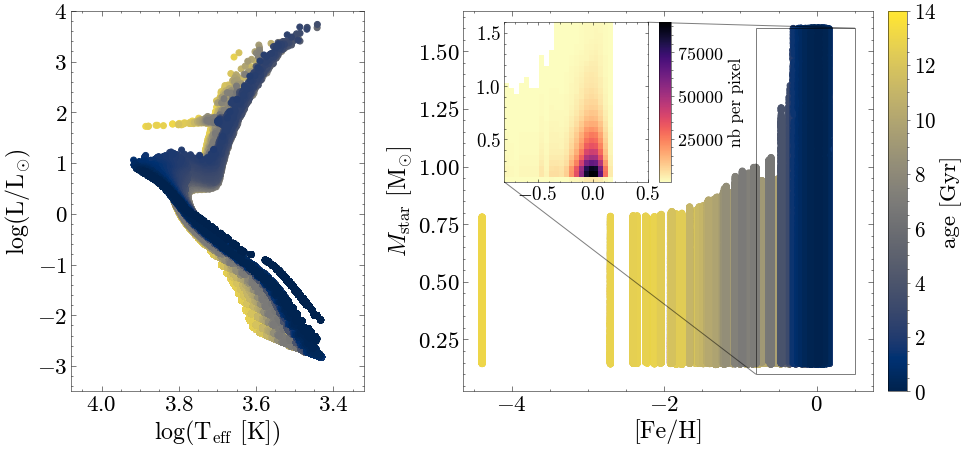

In [16]:
temp = sample_SN.singles
fs = 24
cmap_age = 'cividis'
# HRd for all stars in SN + mass-metallicity plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), 
                               gridspec_kw={'width_ratios':[0.37, 0.63]}, 
                               sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.25)

####### HRd of all stars in SN of g755e11
ax1.scatter(np.log10(temp['teff']), temp['logl'],
            c=temp['age_pc'], rasterized=True, cmap=cmap_age, vmin=0, vmax=14)

ax1.invert_xaxis()
ax1.set_xlabel(r'log($\rm T_{eff}$ [K])', fontsize=fs)
ax1.set_ylabel(r'log(L/$\rm L_{\odot}$)', fontsize=fs)
ax1.axis([4.08, 3.32, -3.5, 4])
ax1.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax1.tick_params(axis='both', which='minor', length=2)

####### mass-metallicity plot
color_age = ax2.scatter(temp['feh'], temp['mass_star_rvs'],
            c=temp['age_pc'], rasterized=True, cmap=cmap_age, vmin=0, vmax=14)
ax2.set_ylabel(r'$M_{\rm star}$ [$\rm M_{\odot}$]', fontsize=fs)
ax2.set_xlabel('[Fe/H]', fontsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax2.tick_params(axis='both', which='minor', length=2)

cbar_age = fig.colorbar(color_age, ax=ax2, pad=0.03)
cbar_age.set_label('age [Gyr]', fontsize=fs-1)
cbar_age.ax.tick_params(labelsize=fs-3, direction='out', which='both')

axins = ax2.inset_axes([0.1, 0.55, 0.35, 0.42], # where to put the new axis (x0, y0, width, height)
                        xlim=(-0.8, 0.5), ylim=(0.1, 1.6)) # lim of sub axis
dens_zoom = axins.hist2d(temp['feh'].values, temp['mass_star_rvs'].values, density=False,
             rasterized=True,
             bins=(np.linspace(-0.8, 0.5, 30), np.linspace(0.1, 1.6, 30)),
             cmap='magma_r', cmin=0.1)


#############
[[x10,y10],[x11,y11]] = axins.get_position().get_points()
pad = 0.01; width = 0.01
cbar_zoom_ax = fig.add_axes([x11+pad, y10, width, (y11-y10)])
cbar_zoom_ax.yaxis.set_ticks_position('right')
cbar_zoom = fig.colorbar(dens_zoom[3], cax=cbar_zoom_ax)
cbar_zoom_ax.tick_params(labelsize=fs-6, which='both', direction='out')
cbar_zoom.set_label('nb per pixel', fontsize=fs-7)

#############

ax2.indicate_inset_zoom(axins, edgecolor="black")
axins.set_ylabel(None)
axins.tick_params(axis='both', which='major', labelsize=fs-5)

#plt.savefig("./figures/HRd_FeHmass_SN_755e11_23oct25.pdf", bbox_inches='tight')

plt.show()

# Fig.6: $T_{eff}$ vs $S$

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
cmap = plt.get_cmap('gnuplot2_r')
cmap2 = plt.get_cmap('magma_r')
new_gnuplot2r = truncate_colormap(cmap, 0.01, 0.9)
new_magmar = truncate_colormap(cmap2, 0, 0.9)

In [3]:
limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

In [9]:
det_pl_ONLYrad = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYrad.fits").to_pandas()
det_pl_ONLYmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYmass.fits").to_pandas()
det_pl_radANDmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_radANDmass.fits").to_pandas()
detected_planets = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_all.fits").to_pandas()

In [5]:
d = {'radius_star': [1, 1, 1, 1, 1, 1, 1, 1], # in R_sun
     'a_AU': [0.387098, 0.723332, 1, 1.523680, 5.2038, 9.5826, 19.19126, 30.07],
     'teff': [5778, 5778, 5778, 5778, 5778, 5778, 5778, 5778],
     'mass_planet': [0.055, 0.815, 1, 0.107, 317.8, 95.159, 14.536, 17.147]} # in M_earth
syst_sol = pd.DataFrame(data = d)
syst_sol['insolation'] = UTILS.ComputeInsolation_obs(syst_sol['radius_star']*u.R_sun.to(u.m), syst_sol['a_AU'], syst_sol['teff'])[1]


In [6]:
### import stars table for the SN
sample_SN = UTILS.PlanetSample()
sample_SN.load_previously_computed_files_PLOTS('SN_755e11', '25juliol24_rerun_3mars25_AltMet', 
                                         load_allstars=False, 
                                         load_singles=False, 
                                         load_binaries=False, 
                                         load_multiples=False, 
                                         load_planets=True, 
                                         load_singles_with_planetcols=True,
                                         path='./data/plots_files/')

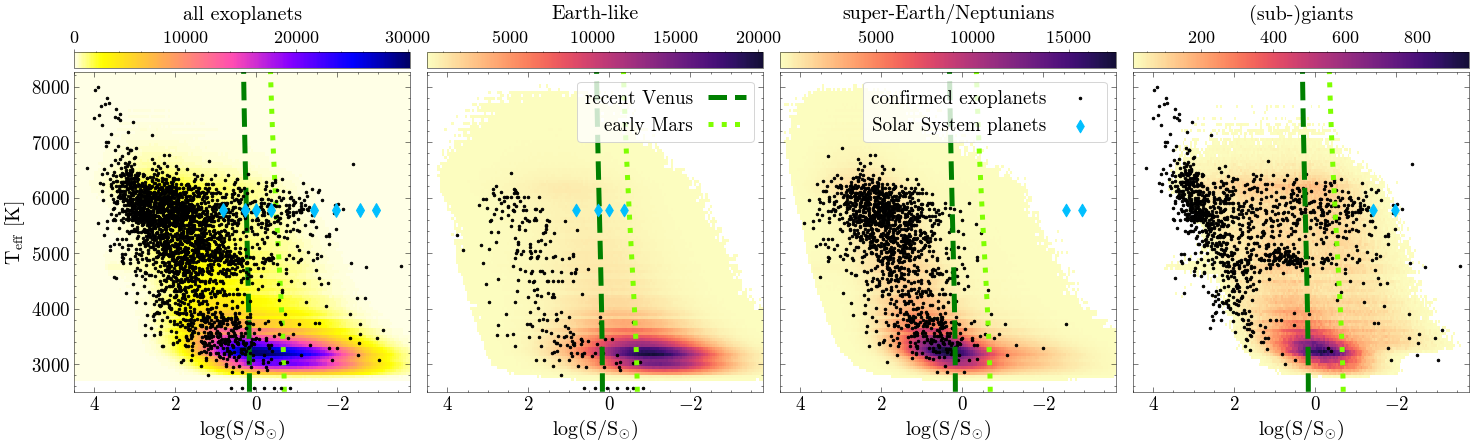

In [ ]:
### test en utilisant masse to classify simulated exopl
fs=20
### same but compare distrib od ! planetary types...

obs_plnts_rad = pd.concat([det_pl_ONLYrad, det_pl_radANDmass])
obs_plnts_mass = det_pl_ONLYmass

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25,7), sharex=True, sharey=True, gridspec_kw={'width_ratios': [0.8, 0.8, 0.8, 0.8]})
plt.subplots_adjust(wspace=0.05)
step = 1
teff_range = np.linspace(2500, sample_SN.singles.teff.max(), 100)

### all stars
col1 = ax0.hist2d(np.log10(sample_SN.planets.dropna(subset='insolation')['insolation'][::step].astype(float)), sample_SN.planets.dropna(subset='insolation')['teff_star'][::step], 
           bins=(200, 100), cmap=new_gnuplot2r, density=False, cmin=0, rasterized=True) #, norm=colors.LogNorm())

### plot the recent Venus and early Mars boundaries
ax0.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[0]), teff_range, '--', c='green', 
         label='recent Venus', lw=5)
ax0.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[1]), teff_range, ':', c='chartreuse', 
         label='early Mars', lw=5)

### plot the confirmed exopl
ax0.plot(np.log10(detected_planets['insolation'].values.astype(float)), detected_planets['st_teff'].values, '.', 
         ms=5, c='k', label='confirmed exoplanets', rasterized=True)
ax0.plot(np.log10(syst_sol['insolation'].values), syst_sol['teff'].values, 'd',
         ms=10, c='deepskyblue', zorder=10)

planetary_types = ['Earth-like', 'super-Earth/Neptunians', '(sub-)giants']
axes = [ax1, ax2, ax3]
min_cut = [10, 10, 10]
cat_cut_rad_obs = [obs_plnts_rad["pl_rade"]<limR_Earth_to_SEnept, 
           (obs_plnts_rad["pl_rade"]<limR_SEnept_to_giants) & (obs_plnts_rad["pl_rade"]>=limR_Earth_to_SEnept), 
           obs_plnts_rad["pl_rade"]>=limR_SEnept_to_giants]
cat_cut_mass_obs = [obs_plnts_mass['pl_bmasse']<limM_Earth_to_SEnept, 
                     (obs_plnts_mass['pl_bmasse']<limM_SEnept_to_giants) & (obs_plnts_mass['pl_bmasse']>=limM_Earth_to_SEnept), 
                     obs_plnts_mass['pl_bmasse']>=limM_SEnept_to_giants]
cat_cut_mass_systsol = [syst_sol['mass_planet']<limM_Earth_to_SEnept, 
                     (syst_sol['mass_planet']<limM_SEnept_to_giants) & (syst_sol['mass_planet']>=limM_Earth_to_SEnept), 
                     syst_sol['mass_planet']>=limM_SEnept_to_giants]
### cut mass for simulated exopl
cat_cut_mass_simu = [sample_SN.planets['mass_planet']<limM_Earth_to_SEnept, 
                     (sample_SN.planets['mass_planet']<limM_SEnept_to_giants) & (sample_SN.planets['mass_planet']>=limM_Earth_to_SEnept), 
                     sample_SN.planets['mass_planet']>=limM_SEnept_to_giants]

labels_legends = [['recent Venus', 'early Mars', None, None],
                  [None, None, 'confirmed exoplanets', 'Solar System planets'],
                  [None, None, None, None],
                  [None, None, None, None]]

for cat in range(3):
    ax = axes[cat]

    ### plot HZ limits + place created exoplanets
    plnts_plt = sample_SN.planets[cat_cut_mass_simu[cat]]
    obs_plnts_rad_cat = obs_plnts_rad[cat_cut_rad_obs[cat]]
    obs_plnts_mass_cat = obs_plnts_mass[cat_cut_mass_obs[cat]]
    syst_sol_mass_cat = syst_sol[cat_cut_mass_systsol[cat]]

    col = ax.hist2d(np.log10(plnts_plt['insolation'][::step].astype(float)), plnts_plt['teff_star'][::step], 
           bins=(200, 100), cmap=new_magmar, cmin=10, density=False, rasterized=True)#, cmin=min_cut[cat]) #vmin=0, vmax=col1[3].get_clim()[1], cmin=10) #, vmax=0.0005)#, norm=colors.LogNorm()) vmax=0.0004 #, vmin=0, vmax=100000)

    ### plot the recent Venus and early Mars boundaries
    ax.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[0]), teff_range, '--', c='green', 
            label=labels_legends[cat][0], lw=5)
    ax.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[1]), teff_range, ':', c='chartreuse', 
            label=labels_legends[cat][1], lw=5)

    ax.scatter(np.log10(obs_plnts_rad_cat['insolation'].values), obs_plnts_rad_cat['st_teff'].values, 
           s=25, c='k', label=labels_legends[cat][2], marker='.', rasterized=True) #obs_plnts_size_cat['pl_rade']*2
    ax.scatter(np.log10(obs_plnts_mass_cat['insolation'].values), obs_plnts_mass_cat['st_teff'].values, 
           s=25, c='k', marker='.', rasterized=True)
    ax.scatter(np.log10(syst_sol_mass_cat['insolation'].values), syst_sol_mass_cat['teff'].values, 
           s=80, c='deepskyblue', marker='d', label=labels_legends[cat][3], zorder=10) #'Solar System planets')
    
    ax.set_xlim([3, -2])
    ax.set_ylim([2500, teff_range.max()])
    ax.set_xlabel(r'log(S/S$_{\odot}$)', fontsize=fs)

    ax.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
    ax.tick_params(axis='both', which='minor', length=2)
    ### color bar
    if cat == 0:
        cbar = fig.colorbar(col[3], ax=ax, location='top', pad=0.01)
    else:
        cbar = fig.colorbar(col[3], ax=ax, location='top', pad=0.01)
    cbar.set_label(planetary_types[cat], fontsize=fs, labelpad = 10)
    cbar.ax.tick_params(labelsize=fs-2, which='both', direction='out')
    

cbar0 = fig.colorbar(col1[3], ax=ax0, location='top', pad=0.01)

ax0.set_xlim((4.5, -3.8))
ax0.set_ylabel(r'T$_{\rm eff}$ [K]', fontsize=fs)

ax0.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax0.tick_params(axis='both', which='minor', length=2)

ax0.set_xlabel(r'log(S/S$_{\odot}$)', fontsize=fs)

cbar0.set_label('all exoplanets', fontsize=fs, labelpad = 10)
cbar0.ax.tick_params(labelsize=fs-2, which='both', direction='out')

ax1.legend(fontsize=fs-1, loc='upper right', frameon=True, markerfirst=False)
ax2.legend(fontsize=fs-1, loc='upper right', frameon=True, markerfirst=False)

#plt.savefig("figures/HZ_limits_density_comparison_SN755e11_simu_detected_bettertypeseparation_11agost25.pdf", bbox_inches='tight')

plt.show()

# Fig. 7: stellar properties, hosting vs non-hosting stars
### <span style="color:red">(takes 4~5 minutes to run)</span>

In [ ]:
### import stars table for the SN
sample_SN = UTILS.PlanetSample()
sample_SN.load_previously_computed_files('SN_755e11', '25juliol24_rerun_3mars25_AltMet', 
                                         load_allstars=False, 
                                         load_singles=False, 
                                         load_binaries=False, 
                                         load_multiples=False, 
                                         load_planets=False, 
                                         load_singles_with_planetcols=True,
                                         path='./data/plots_files/')
sample_SN.df = pd.read_parquet("data/" + 'SN_755e11' + "_ALLSTARS_" + '25juliol24' + ".parquet")

SN_755e11


In [10]:
no_plnts = sample_SN.singles.query("have_Earthlike == False & have_SE_nept == False & have_giants == False")
with_plnts = sample_SN.singles.loc[sample_SN.singles.index.difference(no_plnts.index)]

235.41073261399288


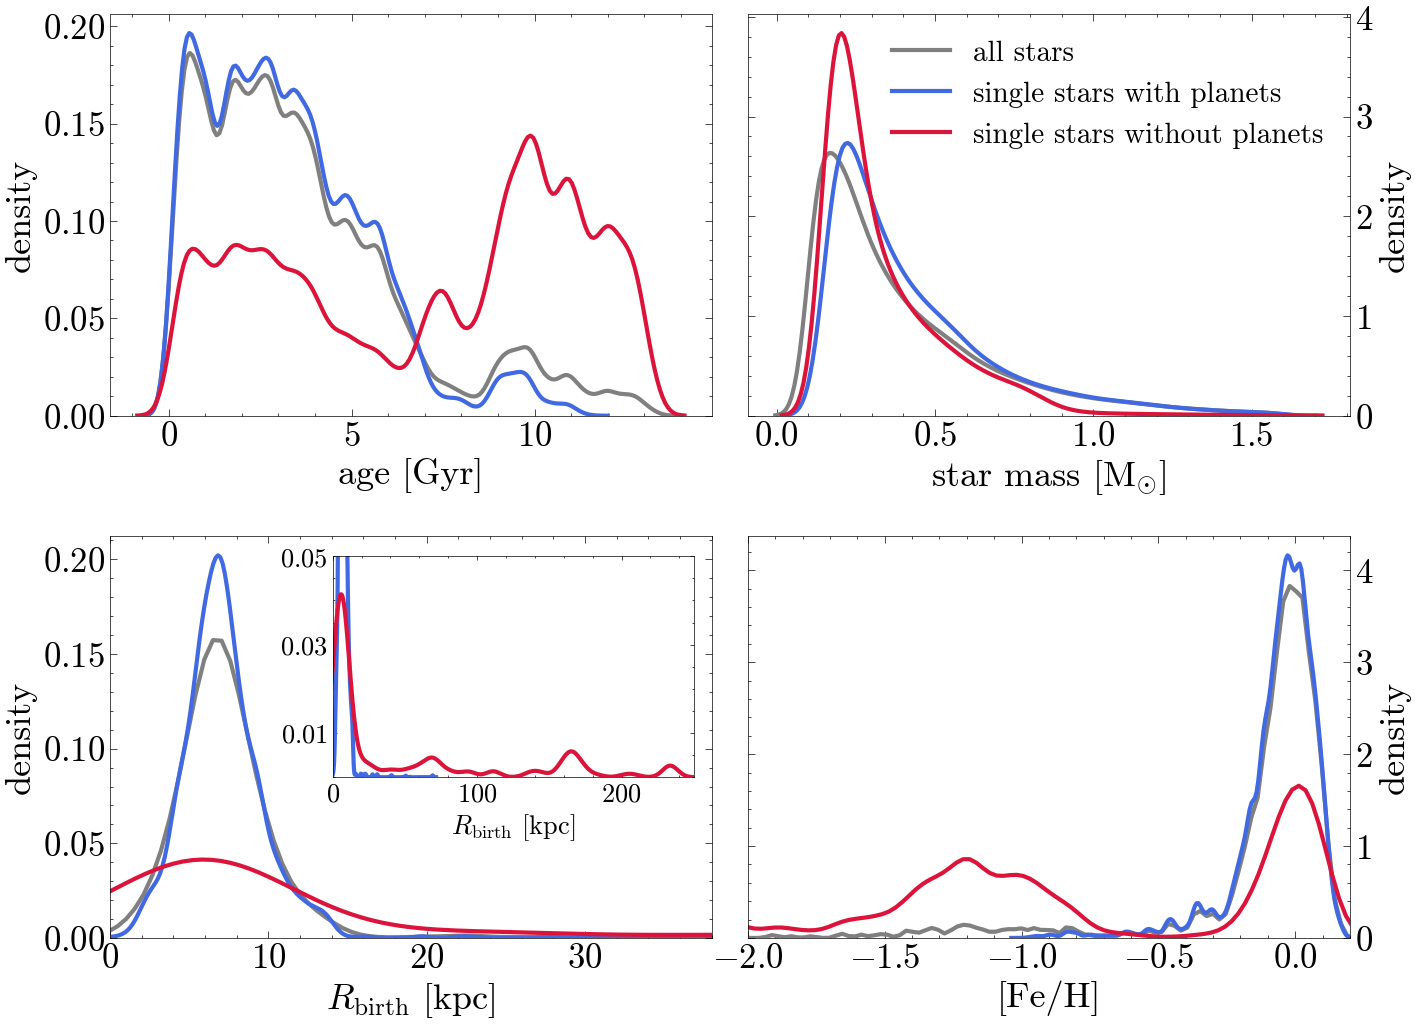

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

fs = 26
bw = 3
linew = 3

starttime = timer()
### age distribution
sb.kdeplot(data=sample_SN.df['age'], ax=ax1, bw_adjust=bw-1, label='all stars', color='grey', lw=linew)
sb.kdeplot(data=with_plnts['age'], ax=ax1, bw_adjust=bw-1, label='single stars with planets', color='royalblue', lw=linew)
sb.kdeplot(data=no_plnts['age'], ax=ax1, bw_adjust=bw-2, label='single stars without planets', color='crimson', lw=linew)

### rbirth distribution
sb.kdeplot(data=sample_SN.df['mass_star_rvs'], ax=ax2, bw_adjust=bw, label='all stars', color='grey', lw=linew)
sb.kdeplot(data=with_plnts['mass_star_rvs'], ax=ax2, bw_adjust=bw, label='single stars with planets', color='royalblue', lw=linew)
sb.kdeplot(data=no_plnts['mass_star_rvs'], ax=ax2, bw_adjust=bw, label='single stars without planets', color='crimson', lw=linew)

### mass distribution
sb.kdeplot(data=sample_SN.df['rbirth'], ax=ax3, bw_adjust=bw-2, gridsize=500, label='all stars', color='grey', lw=linew)
sb.kdeplot(data=with_plnts['rbirth'], ax=ax3, bw_adjust=bw, gridsize=500, label='single stars with planets', color='royalblue', lw=linew)
sb.kdeplot(data=no_plnts['rbirth'], ax=ax3, bw_adjust=bw-2, gridsize=500, label='single stars without planets', color='crimson', lw=linew)

### metallicity distribution
sb.kdeplot(data=sample_SN.df['feh'], ax=ax4, bw_adjust=bw-2, label='all stars', color='grey', lw=linew)
sb.kdeplot(data=with_plnts['feh'], ax=ax4, bw_adjust=bw-1, label='single stars with planets', color='royalblue', lw=linew)
sb.kdeplot(data=no_plnts['feh'], ax=ax4, bw_adjust=bw-2, label='single stars without planets', color='crimson', lw=linew)

### add zoom-out for Rbirth
axins = ax3.inset_axes([0.37, 0.4, 0.6, 0.55], # where to put the new axis (x0, y0, width, height)
                        xlim=(0, 250), ylim=(0, 0.019)) # lim of sub axis
sb.kdeplot(data=with_plnts['rbirth'], ax=axins, bw_adjust=bw, gridsize=500,lw=linew, color='royalblue')
sb.kdeplot(data=no_plnts['rbirth'], ax=axins, bw_adjust=bw-2, gridsize=500,lw=linew, color='crimson')

### axes
fig.subplots_adjust(wspace=0.06, hspace=0.3)

ax1.set_xlabel("age [Gyr]", fontsize=fs)
ax3.set_xlabel(r"$R_{\rm birth}$ [kpc]", fontsize=fs)
ax2.set_xlabel(r"star mass [$\rm M_{\odot}$]", fontsize=fs)
ax4.set_xlabel("[Fe/H]", fontsize=fs)

ax1.set_ylabel('density', fontsize=fs)
ax2.set_ylabel('density', fontsize=fs)
ax3.set_ylabel('density', fontsize=fs)
ax4.set_ylabel('density', fontsize=fs)
#ax2.set_ylabel(None)
#ax4.set_ylabel(None)
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position('right')

ax3.set_xlim((0, 38))
ax4.set_xlim((-2, 0.2))

ax1.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax2.tick_params(axis='both', which='major', labelsize=fs-1, length=5, left=True)
ax3.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax4.tick_params(axis='both', which='major', labelsize=fs-1, length=5, left=True)
ax1.tick_params(axis='both', which='minor', length=2)
ax2.tick_params(axis='both', which='minor', length=2, left=True)
ax3.tick_params(axis='both', which='minor', length=2)
ax4.tick_params(axis='both', which='minor', length=2, left=True)

axins.set_xlabel(r"$R_{\rm birth}$ [kpc]", fontsize=fs-7)
axins.set_ylabel(None)
axins.tick_params(axis='both', which='major', labelsize=fs-7)
axins.set_yticks([0.01, 0.03, 0.05])

ax2.legend(fontsize=fs-5)
print(timer()-starttime)
#plt.savefig("figures/resume_stars_SN_14juliol25_AltMet.pdf", bbox_inches='tight')
plt.show()

# Fig. 8: Kepler field properties

In [2]:
observed_fraction_W21_data = pd.read_csv("data/plots_files/obs_frac_Kepler_Wolniewicz21.csv", names=['Gmag', 'obs_frac'])
total_count_W21_data = pd.read_csv("data/plots_files/total_Kepler_Wolniewicz21_best.csv", names=['Gmag', 'count']).sort_values(by='Gmag')
obs_count_W21_data = pd.read_csv("data/plots_files/observed_Kepler_Wolniewicz21_best.csv", names=['Gmag', 'count']).sort_values(by='Gmag')

### def a fct to interpolate observed fraction by Wolniewicz+21
def observed_fraction_fig2b_W21(Gmag):
    """
    from data of Fig.2 (b) of Wolniewicz+21, 
    showing the Percentage of stars observed as a function of their Kepler magnitude
    interpolate data from 11 to 18 magn and extrapolate before
    """
    return np.interp(Gmag, observed_fraction_W21_data['Gmag'].values, 
                     observed_fraction_W21_data['obs_frac'].values)

def tot_W21(Gmag):
    return np.interp(Gmag, total_count_W21_data['Gmag'].values, 
                     total_count_W21_data['count'].values)

def obs_W21(Gmag):
    return np.interp(Gmag, obs_count_W21_data['Gmag'].values, 
                     obs_count_W21_data['count'].values)

Gmag_range = np.linspace(11, 18, 70)

### def a fct to interpolate observed fraction by Wolniewicz+21
def observed_fraction_fig2a_W21(Gmag):
    return obs_W21(Gmag)/tot_W21(Gmag)
### def a fct to interpolate observed fraction by Wolniewicz+21, plus add a caida between 15.5 and 16
def observed_fraction_fig2b_W21_caida(Gmag):
    """
    from data of Fig.2 (b) of Wolniewicz+21, 
    showing the Percentage of stars observed as a function of their Kepler magnitude
    interpolate data from 11 to 18 magn and extrapolate before
    """
    ### first, modify the 'observed_fraction_W21_data'
    observed_fraction_W21_data_caida = observed_fraction_W21_data.copy(deep=True)
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>=15.5].index,'obs_frac'] = observed_fraction_fig2a_W21(observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>=15.5].index,'Gmag'].values)/observed_fraction_fig2a_W21(15.5) * observed_fraction_fig2b_W21(15.5)
    ### set observed fraction to 1 if magn <= 12 and to 0 if magn > 16
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>16].index,'obs_frac'] = 0.
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']<=12].index,'obs_frac'] = 1.#observed_fraction_fig2b_W21(12)

    return np.interp(Gmag, observed_fraction_W21_data_caida['Gmag'].values, 
                     observed_fraction_W21_data_caida['obs_frac'].values)

In [3]:
st_kepler = pd.read_parquet("data/plots_files/ext_Keplerfov_allsubs_SINGLES_and_PLANETSstats_18mars25_K2fov.parquet")
pl_kepler = pd.read_parquet("data/plots_files/ext_Keplerfov_allsubs_PLANETS_18mars25_K2fov.parquet")

### W21 
W21 = Table.read("data/plots_files/W21_crossmatch_SH.fits").to_pandas()

A_G = st_kepler['Gmag'] - st_kepler['G_gaiaedr3'] - 5*np.log10(st_kepler['dist']*1000) +5

mask_obs = W21["Obs"] == 1
mask_mag16 = W21['phot_g_mean_mag']<16
mask_mag6 = W21['phot_g_mean_mag']>6
mask_mass = W21['xgb_mass']<1.6

W21_obs = W21[mask_obs & mask_mag16 & mask_mag6 & mask_mass]

###### simu in Kepler field

#### mask deleting giants with Gmag > 14
cond_giants = (st_kepler["Gmag"] > 14) & (st_kepler["logg"] <= 4)

#### observed fraction (b), modify to match caida between 15.5 and 16 mag...
st_kepler['Obs_b_caida'] = (np.random.uniform(size=len(st_kepler)) < observed_fraction_fig2b_W21_caida(st_kepler['Gmag']))
st_kepler.loc[st_kepler[st_kepler['Gmag'] > 16].index, 'Obs_b_caida'] = False

mask_obs_B_caida = st_kepler['Obs_b_caida'] == True

st_obs = st_kepler[mask_obs_B_caida & ~cond_giants]
st_obs = st_obs[st_obs['Gmag'] >= 6]

### st_obs final: magn cuts + W21 magn fct
st_kepler['in_st_obs'] = False
st_kepler.loc[st_obs.index, 'in_st_obs'] = True
pl_kepler['in_st_obs'] = st_kepler['in_st_obs'].repeat((st_kepler.nb_Earthlike + st_kepler.nb_SE_nept + st_kepler.nb_giants).values.astype(int)).values


####### exoplanets detected by Kepler
exopl_kepler = Table.read("data/plots_files/cumulative_2025_01_24_crossmatchSH.votable").to_pandas()
### take out False Positives
exopl_kepler = exopl_kepler[~(exopl_kepler['koi_disposition']=="FALSE POSITIVE")]
### delete empty lines (106)
exopl_kepler = exopl_kepler.dropna(subset=['koi_prad']).reset_index()

filter_confirmed = exopl_kepler['koi_disposition'] == 'CONFIRMED'
filter_candidate = exopl_kepler['koi_disposition'] == 'CANDIDATE'

print("all Kepler planets:", len(exopl_kepler))
print("confirmed:", len(exopl_kepler[filter_confirmed]))
print("candidates:", len(exopl_kepler[filter_candidate]))

exopl_kepler['insolation'] = UTILS.ComputeInsolation_obs(exopl_kepler['Rad']*u.R_sun.to(u.m), exopl_kepler['koi_sma'], exopl_kepler['koi_steff'])[1]

all Kepler planets: 4619
confirmed: 2741
candidates: 1878


In [4]:
# draw rdm inclination for each STAR
#st_kepler['i_deg'] = np.random.uniform(0, 90, len(st_kepler))
cosi = np.random.uniform(0, 1, len(st_kepler))
st_kepler['i_deg'] = np.arccos(cosi)*u.rad.to(u.deg)

# copy value for each planet of this host star
pl_kepler['i_deg'] = st_kepler['i_deg'].repeat((st_kepler.nb_Earthlike + st_kepler.nb_SE_nept + st_kepler.nb_giants).values.astype(int)).values

del cosi

##### computing SNR etc (< 3 sec)
pl_kepler = UTILS.compute_detection_nb_simu(pl_kepler)

pl_obs = pl_kepler[pl_kepler['in_st_obs'] == True]
mask_tdur = pl_obs['tdur_h'] > 0.
pl_obs = pl_obs[mask_tdur]
print(len(pl_obs), "planets have an inclination and a magnitude compatible with observation")

### planets considered observables if SNR >7.1
pl_detect = pl_obs[pl_obs['SNR']>=7.1]
print(len(pl_detect))

### filter detectable planets' host stars
hoststar_pl_detect = pl_detect.id_hoststar.unique()
print(len(hoststar_pl_detect))

# st_detect_pl: df with only host stars of detectable planets
mask_star_with_detectedpl = st_obs.index.isin(hoststar_pl_detect)
st_detect_pl = st_obs[mask_star_with_detectedpl]

### Initial nb of planets: 24337580
### nb with incl compatible with transit det: 598087
### computing transit depth
### assigning CDPP...
### computing nb of transits
### computing SNR..
14821 planets have an inclination and a magnitude compatible with observation
6180
2423


In [5]:
pl_detect

index  id_hoststar  mass_star  radius_star  logl_star  \
106959      952672       222397   0.878512     1.485091      0.429   
106961      952674       222397   0.878512     1.485091      0.429   
119615     1047887       226697   0.813687     0.986855      0.092   
240364     1982151       269150   0.890331     1.497798      0.436   
240365     1982152       269150   0.890331     1.497798      0.436   
...            ...          ...        ...          ...        ...   
24329422  29510947      3742471   1.397586     1.336144      0.590   
24329423  29510948      3742471   1.397586     1.336144      0.590   
24329424  29510949      3742471   1.397586     1.336144      0.590   
24329462  29511388      3742475   1.301619     1.234676      0.431   
24329463  29511389      3742475   1.301619     1.234676      0.431   

            teff_star  mh_star   age_star planet_type  mass_planet  ...  \
106959    6063.173557    -0.65  10.431948     SE_nept    15.202977  ...   
106961    6063.173557    -0.65  10.431948     SE_nept    22.129349  ...   
119615    6126.324544    -0.75  10.416777   Earthlike     1.385491  ...   
240364    6061.777620    -0.60  10.039181     SE_nept     8.657179  ...   
240365    6061.777620    -0.60  10.039181     SE_nept     4.259106  ...   
...               ...      ...        ...         ...          ...  ...   
24329422  7012.938010    -0.05   0.009283     SE_nept    12.874279  ...   
24329423  7012.938010    -0.05   0.009283     SE_nept     3.727721  ...   
24329424  7012.938010    -0.05   0.009283     SE_nept    12.742636  ...   
24329462  6657.328694    -0.05   0.009283     SE_nept     5.900857  ...   
24329463  6657.328694    -0.05   0.009283     SE_nept    10.733668  ...   

          radius_planet  in_st_obs      i_deg    tdur_h  transit_depth  \
106959         5.109433       True  84.840342  3.528251     994.896242   
106961         4.980368       True  84.840342  3.528183     945.268677   
119615         1.154014       True  86.172234  2.312099     114.935566   
240364         1.895599       True  89.460936  4.343507     134.624843   
240365         1.661261       True  89.460936  6.076076     103.396997   
...                 ...        ...        ...       ...            ...   
24329422       2.154679       True  88.030200  1.915130     218.573528   
24329423       1.554580       True  88.030200  2.377846     113.778016   
24329424       3.366004       True  88.030200  3.152937     533.410481   
24329462       1.759909       True  86.319382  2.610216     170.770497   
24329463       4.445780       True  86.319382  2.614605    1089.753377   

          t_CDPP      CDPP_N    CDPP_eff         N_tr         SNR  
106959       6.0  209.256259  272.881650   444.583443   76.874110  
106961       6.0  168.577523  219.836466   444.624904   90.667664  
119615       6.0  144.449145  232.695186   387.577328    9.724029  
240364       6.0  236.517515  277.983275   373.008990    9.353329  
240365       6.0  168.358073  167.300789   132.848384    7.123412  
...          ...         ...         ...          ...         ...  
24329422     6.0   79.280834  140.328130    61.218666   12.186942  
24329423     6.0   75.910490  120.582849  1018.192306   30.108403  
24329424     6.0   68.285828   94.199485   392.710276  112.214545  
24329462     6.0  154.511123  234.259476   335.085790   13.344235  
24329463     6.0  226.102982  342.514450   357.056938   60.119874  

[6180 rows x 31 columns]

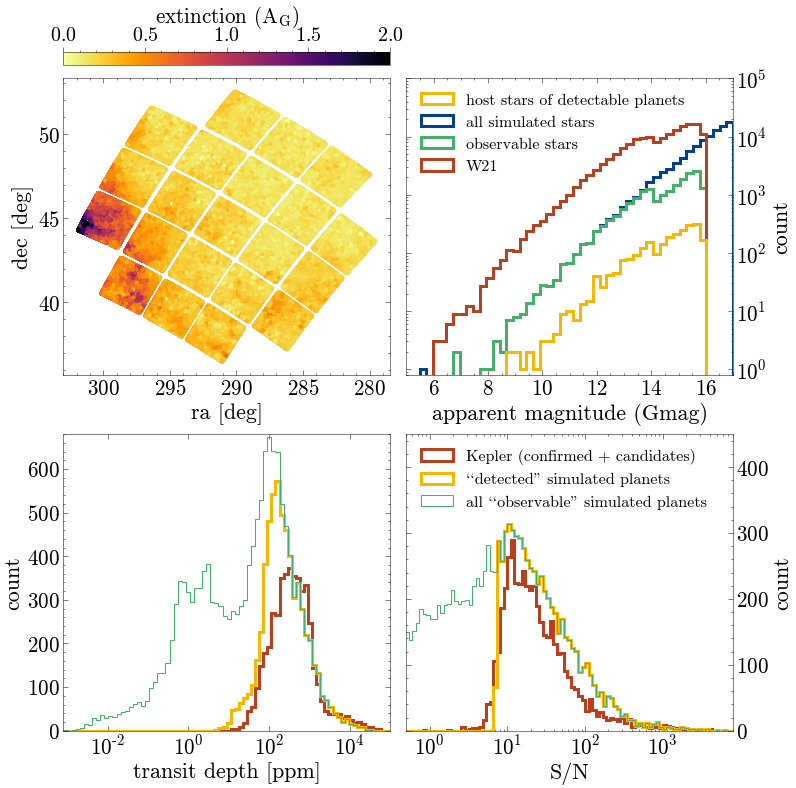

In [ ]:
fs=22
bins_mag = np.linspace(5, 17, 50)
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
fig.subplots_adjust(wspace=0.05)

color_W21 = "#BA3F1D"
color_allsimustars = "#003F91"
color_obsstars = "#44AF69"
color_HS_det = "#F5B700"

A_G = st_kepler['Gmag'] - st_kepler['G_gaiaedr3'] - 5*np.log10(st_kepler['dist']*1000) +5
col = ax.scatter(st_kepler['ra_star'].values*u.rad.to(u.deg), st_kepler['dec_star'].values*u.rad.to(u.deg), s=10, 
           label='simulated fov', c=A_G, cmap='inferno_r', vmax=2, rasterized=True)

ax.set_xlabel('ra [deg]', fontsize=fs)
ax.set_ylabel('dec [deg]', fontsize=fs)
ax.invert_xaxis()
ax.tick_params(axis='both', which='major', labelsize=fs-1)
ax.tick_params(axis='both', which='major', length=5)
ax.tick_params(axis='both', which='minor', length=2)

#left, bottom, width, height
[[x00,y00],[x01,y01]] = ax.get_position().get_points()

cbar_ax = fig.add_axes([x00, y01+0.015, x01-x00, 0.015])
cbar = fig.colorbar(col, cax=cbar_ax, orientation='horizontal')
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
cbar_ax.tick_params(labelsize=fs-4, which='both', direction='out')
cbar_ax.tick_params(which='major', length=5)
cbar_ax.tick_params(which='minor', length=2)
cbar.set_label(r'extinction ($\rm A_G$)', fontsize=fs-1)
cbar_ax.tick_params(labelsize=fs-2)

ax2.hist(st_detect_pl['Gmag'], histtype='step', bins=bins_mag, density=False, lw=3, 
         label='host stars of detectable planets', color=color_HS_det, zorder=10)
ax2.hist(st_kepler['Gmag'], histtype='step', bins=bins_mag, density=False, lw=3, 
         label='all simulated stars', color=color_allsimustars)
ax2.hist(st_obs['Gmag'], histtype='step', bins=bins_mag, density=False, lw=3, 
         label='observable stars', color=color_obsstars, zorder=2)
ax2.hist(W21_obs['phot_g_mean_mag'], histtype='step', bins=bins_mag, density=False, lw=3, 
         label='W21', color=color_W21)

ax2.set_xlabel('apparent magnitude (Gmag)', fontsize=fs)
ax2.tick_params(which='both', labelsize=fs-1, right=True, labelleft=False, labelright=True)
ax2.tick_params(axis='y', which='both', direction='in', left=True)
ax2.tick_params(axis='both', which='major', length=5)
ax2.tick_params(axis='both', which='minor', length=2)

ax2.xaxis.set_ticks([6, 8, 10, 12, 14, 16])
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('count', fontsize=fs)

ax2.legend(loc='upper left', fontsize=fs-6, frameon=False)
ax2.set_yscale('log')
ax2.set_xlim(5, 17)
ax2.set_ylim(0.8, 1e5)

#####################

ax3.hist(exopl_kepler['koi_depth'], bins=np.logspace(-4, 6, 100), histtype='step', 
         label='Kepler confirmed + candidates', lw=3, color=color_W21)
ax3.hist(pl_detect['transit_depth'], bins=np.logspace(-4, 6, 100), histtype='step', 
         label='"detected" simulated planets', lw=3, color=color_HS_det)
ax3.hist(pl_obs['transit_depth'], bins=np.logspace(-4, 6, 100), histtype='step', 
         label='all observable simulated planets', lw=1, color=color_obsstars)

ax4.hist(exopl_kepler['koi_model_snr'], bins=np.logspace(-0.5, 4, 100), histtype='step', 
         label='Kepler (confirmed + candidates)', lw=3, color=color_W21)
ax4.hist(pl_detect['SNR'], bins=np.logspace(-0.5, 4, 100), histtype='step', 
         label='``detected" simulated planets', lw=3, color=color_HS_det)
ax4.hist(pl_obs['SNR'], bins=np.logspace(-0.5, 4, 100), histtype='step',
          label='all ``observable" simulated planets', lw=1, color=color_obsstars)

ax3.set_xscale('log')
ax3.set_xlabel('transit depth [ppm]', fontsize=fs)
ax3.set_ylabel('count', fontsize=fs)
ax3.set_xlim(0.0008, 1e5)
ax3.set_ylim(0, 680)
ax4.set_xlim(5e-1, 8e3)
ax4.set_ylim(0, 450)

ax3.tick_params(axis='both', which='both', labelsize=fs-1, top=True, bottom=True)
ax4.tick_params(which='both', labelsize=fs-1, right=True, labelleft=False, labelright=True)
ax4.tick_params(axis='y', which='both', direction='in', left=True)
ax3.tick_params(axis='both', which='major', length=5)
ax3.tick_params(axis='both', which='minor', length=2)
ax4.tick_params(axis='both', which='major', length=5)
ax4.tick_params(axis='both', which='minor', length=2)

ax4.set_xscale('log')
ax4.set_xlabel('S/N', fontsize=fs)
ax4.yaxis.set_label_position('right')
ax4.set_ylabel('count', fontsize=fs)

ax4.legend(loc='upper left', fontsize=fs-6, frameon=False)

#plt.savefig("./figures/Kepler_fov_extinction_histo_magn_trdepth_SNR_14juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig.9: Teff vs S for Kepler field

In [2]:
### upload detected planets
detected_planets = Table.read("data/plots_files/PS_2025.07.02_09.35.22_all.fits")

det_kepler = detected_planets[detected_planets['disc_facility']=='Kepler']
det_kepler = det_kepler.to_pandas()
det_kepler.loc[:, 'log_insolation'] = np.log10(det_kepler.loc[:, 'insolation'])

det_pl_ONLYrad = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYrad.fits").to_pandas()
det_pl_ONLYmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_ONLYmass.fits").to_pandas()
det_pl_radANDmass = Table.read("./data/plots_files/PS_2025.07.02_09.35.22_planets_radANDmass.fits").to_pandas()

In [3]:
limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
cmap = plt.get_cmap('gnuplot2_r')
cmap2 = plt.get_cmap('magma_r')
new_gnuplot2r = truncate_colormap(cmap, 0.01, 0.9)
new_magmar = truncate_colormap(cmap2, 0, 0.9)

observed_fraction_W21_data = pd.read_csv("data/plots_files/obs_frac_Kepler_Wolniewicz21.csv", names=['Gmag', 'obs_frac'])
total_count_W21_data = pd.read_csv("data/plots_files/total_Kepler_Wolniewicz21_best.csv", names=['Gmag', 'count']).sort_values(by='Gmag')
obs_count_W21_data = pd.read_csv("data/plots_files/observed_Kepler_Wolniewicz21_best.csv", names=['Gmag', 'count']).sort_values(by='Gmag')

### def a fct to interpolate observed fraction by Wolniewicz+21
def observed_fraction_fig2b_W21(Gmag):
    """
    from data of Fig.2 (b) of Wolniewicz+21, 
    showing the Percentage of stars observed as a function of their Kepler magnitude
    interpolate data from 11 to 18 magn and extrapolate before
    """
    return np.interp(Gmag, observed_fraction_W21_data['Gmag'].values, 
                     observed_fraction_W21_data['obs_frac'].values)

def tot_W21(Gmag):
    return np.interp(Gmag, total_count_W21_data['Gmag'].values, 
                     total_count_W21_data['count'].values)

def obs_W21(Gmag):
    return np.interp(Gmag, obs_count_W21_data['Gmag'].values, 
                     obs_count_W21_data['count'].values)

Gmag_range = np.linspace(11, 18, 70)

### def a fct to interpolate observed fraction by Wolniewicz+21
def observed_fraction_fig2a_W21(Gmag):
    return obs_W21(Gmag)/tot_W21(Gmag)
### def a fct to interpolate observed fraction by Wolniewicz+21, plus add a caida between 15.5 and 16
def observed_fraction_fig2b_W21_caida(Gmag):
    """
    from data of Fig.2 (b) of Wolniewicz+21, 
    showing the Percentage of stars observed as a function of their Kepler magnitude
    interpolate data from 11 to 18 magn and extrapolate before
    """
    ### first, modify the 'observed_fraction_W21_data'
    observed_fraction_W21_data_caida = observed_fraction_W21_data.copy(deep=True)
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>=15.5].index,'obs_frac'] = observed_fraction_fig2a_W21(observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>=15.5].index,'Gmag'].values)/observed_fraction_fig2a_W21(15.5) * observed_fraction_fig2b_W21(15.5)
    ### set observed fraction to 1 if magn <= 12 and to 0 if magn > 16
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']>16].index,'obs_frac'] = 0.
    observed_fraction_W21_data_caida.loc[observed_fraction_W21_data_caida[observed_fraction_W21_data_caida['Gmag']<=12].index,'obs_frac'] = 1.#observed_fraction_fig2b_W21(12)

    return np.interp(Gmag, observed_fraction_W21_data_caida['Gmag'].values, 
                     observed_fraction_W21_data_caida['obs_frac'].values)

In [ ]:
st_kepler = pd.read_parquet("data/plots_files/ext_Keplerfov_allsubs_SINGLES_and_PLANETSstats_18mars25_K2fov.parquet")
pl_kepler = pd.read_parquet("data/plots_files/ext_Keplerfov_allsubs_PLANETS_18mars25_K2fov.parquet")

### W21 
W21 = Table.read("data/plots_files/W21_crossmatch_SH.fits").to_pandas()

A_G = st_kepler['Gmag'] - st_kepler['G_gaiaedr3'] - 5*np.log10(st_kepler['dist']*1000) +5

mask_obs = W21["Obs"] == 1
mask_mag16 = W21['phot_g_mean_mag']<16
mask_mag6 = W21['phot_g_mean_mag']>6
mask_mass = W21['xgb_mass']<1.6

W21_obs = W21[mask_obs & mask_mag16 & mask_mag6 & mask_mass]

###### simu in Kepler field

#### mask deleting giants with Gmag > 14
cond_giants = (st_kepler["Gmag"] > 14) & (st_kepler["logg"] <= 4)

#### observed fraction (b), modify to match caida between 15.5 and 16 mag...
st_kepler['Obs_b_caida'] = (np.random.uniform(size=len(st_kepler)) < observed_fraction_fig2b_W21_caida(st_kepler['Gmag']))
st_kepler.loc[st_kepler[st_kepler['Gmag'] > 16].index, 'Obs_b_caida'] = False

mask_obs_B_caida = st_kepler['Obs_b_caida'] == True

st_obs = st_kepler[mask_obs_B_caida & ~cond_giants]
st_obs = st_obs[st_obs['Gmag'] >= 6]

### st_obs final: magn cuts + W21 magn fct
st_kepler['in_st_obs'] = False
st_kepler.loc[st_obs.index, 'in_st_obs'] = True
pl_kepler['in_st_obs'] = st_kepler['in_st_obs'].repeat((st_kepler.nb_Earthlike + st_kepler.nb_SE_nept + st_kepler.nb_giants).values.astype(int)).values


####### exoplanets detected by Kepler
exopl_kepler = Table.read("data/plots_files/cumulative_2025_01_24_crossmatchSH.votable").to_pandas()
### take out False Positives
exopl_kepler = exopl_kepler[~(exopl_kepler['koi_disposition']=="FALSE POSITIVE")]
### delete empty lines (106)
exopl_kepler = exopl_kepler.dropna(subset=['koi_prad']).reset_index()

filter_confirmed = exopl_kepler['koi_disposition'] == 'CONFIRMED'
filter_candidate = exopl_kepler['koi_disposition'] == 'CANDIDATE'

print("all Kepler planets:", len(exopl_kepler))
print("confirmed:", len(exopl_kepler[filter_confirmed]))
print("candidates:", len(exopl_kepler[filter_candidate]))

exopl_kepler['insolation'] = UTILS.ComputeInsolation_obs(exopl_kepler['Rad']*u.R_sun.to(u.m), exopl_kepler['koi_sma'], exopl_kepler['koi_steff'])[1]

# draw rdm inclination for each STAR
cosi = np.random.uniform(0, 1, len(st_kepler))
st_kepler['i_deg'] = np.arccos(cosi)*u.rad.to(u.deg)

# copy value for each planet of this host star
pl_kepler['i_deg'] = st_kepler['i_deg'].repeat((st_kepler.nb_Earthlike + st_kepler.nb_SE_nept + st_kepler.nb_giants).values.astype(int)).values

del cosi

##### computing SNR etc (< 3 sec)
pl_kepler = UTILS.compute_detection_nb_simu(pl_kepler)

pl_obs = pl_kepler[pl_kepler['in_st_obs'] == True]
mask_tdur = pl_obs['tdur_h'] > 0.
pl_obs = pl_obs[mask_tdur]
print(len(pl_obs), "planets have an inclination and a magnitude compatible with observation")

### planets considered observables if SNR >7.1
pl_detect = pl_obs[pl_obs['SNR']>=7.1]
print(len(pl_detect))

### filter detectable planets' host stars
hoststar_pl_detect = pl_detect.id_hoststar.unique()
print(len(hoststar_pl_detect))

# st_detect_pl: df with only host stars of detectable planets
mask_star_with_detectedpl = st_obs.index.isin(hoststar_pl_detect)
st_detect_pl = st_obs[mask_star_with_detectedpl]

all Kepler planets: 4619
confirmed: 2741
candidates: 1878
### Initial nb of planets: 24337580
### nb with incl compatible with transit det: 596971
### computing transit depth
### assigning CDPP...
### computing nb of transits
### computing SNR..
14755 planets have an inclination and a magnitude compatible with observation
6053
2392


In [5]:
cat_cut_mass_simu = [pl_kepler['mass_planet']<limM_Earth_to_SEnept, 
                     (pl_kepler['mass_planet']<limM_SEnept_to_giants) & (pl_kepler['mass_planet']>=limM_Earth_to_SEnept), 
                     pl_kepler['mass_planet']>=limM_SEnept_to_giants]
cat_cut_mass_simu_det = [pl_detect['mass_planet']<limM_Earth_to_SEnept, 
                     (pl_detect['mass_planet']<limM_SEnept_to_giants) & (pl_detect['mass_planet']>=limM_Earth_to_SEnept), 
                     pl_detect['mass_planet']>=limM_SEnept_to_giants]

def planet_categories_rad(df, col_plrad):
    cat_cut_rad = [df[col_plrad]<limR_Earth_to_SEnept, 
                     (df[col_plrad]<limR_SEnept_to_giants) & (df[col_plrad]>=limR_Earth_to_SEnept), 
                     df[col_plrad]>=limR_SEnept_to_giants]
    return cat_cut_rad

print("detectable exoplanets in the simulated Kepler fov:")
print("Earth-like:", len(pl_detect[cat_cut_mass_simu_det[0]]), "(%s %%)"%(np.round(len(pl_detect[cat_cut_mass_simu_det[0]])*100/len(pl_detect), 2)))
print("SE/Nept:", len(pl_detect[cat_cut_mass_simu_det[1]]), "(%s %%)"%(np.round(len(pl_detect[cat_cut_mass_simu_det[1]])*100/len(pl_detect), 2)))
print("giants:", len(pl_detect[cat_cut_mass_simu_det[2]]), "(%s %%)"%(np.round(len(pl_detect[cat_cut_mass_simu_det[2]])*100/len(pl_detect), 2)))

detectable exoplanets in the simulated Kepler fov:
Earth-like: 286 (4.72 %)
SE/Nept: 5254 (86.8 %)
giants: 513 (8.48 %)


In [6]:
cat_cut_rad_kepler = planet_categories_rad(exopl_kepler, 'koi_prad')
cat_cut_rad_confK = planet_categories_rad(exopl_kepler[filter_confirmed], 'koi_prad')
print("all detected exoplanets by Kepler:")
print("Earth-like:", len(exopl_kepler[cat_cut_rad_kepler[0]]), "(%s %%)"%(np.round(len(exopl_kepler[cat_cut_rad_kepler[0]])*100/len(exopl_kepler), 2)))
print("SE/Nept:", len(exopl_kepler[cat_cut_rad_kepler[1]]), "(%s %%)"%(np.round(len(exopl_kepler[cat_cut_rad_kepler[1]])*100/len(exopl_kepler), 2)))
print("giants:", len(exopl_kepler[cat_cut_rad_kepler[2]]), "(%s %%)"%(np.round(len(exopl_kepler[cat_cut_rad_kepler[2]])*100/len(exopl_kepler), 2)))
print("---")
print("confirmed exoplanets by Kepler:")
conf_kepler = exopl_kepler[filter_confirmed]
print("Earth-like:", len(conf_kepler[cat_cut_rad_confK[0]]), "(%s %%)"%(np.round(len(conf_kepler[cat_cut_rad_confK[0]])*100/len(conf_kepler), 2)))
print("SE/Nept:", len(conf_kepler[cat_cut_rad_confK[1]]), "(%s %%)"%(np.round(len(conf_kepler[cat_cut_rad_confK[1]])*100/len(conf_kepler), 2)))
print("giants:", len(conf_kepler[cat_cut_rad_confK[2]]), "(%s %%)"%(np.round(len(conf_kepler[cat_cut_rad_confK[2]])*100/len(conf_kepler), 2)))

all detected exoplanets by Kepler:
Earth-like: 925 (20.03 %)
SE/Nept: 3006 (65.08 %)
giants: 688 (14.89 %)
---
confirmed exoplanets by Kepler:
Earth-like: 379 (13.83 %)
SE/Nept: 2040 (74.43 %)
giants: 322 (11.75 %)


In [7]:
pl_detect.loc[:, 'log_insolation'] = np.log10(pl_detect.loc[:, 'insolation'])

/tmp/ipykernel_274306/809077796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_detect.loc[:, 'log_insolation'] = np.log10(pl_detect.loc[:, 'insolation'])



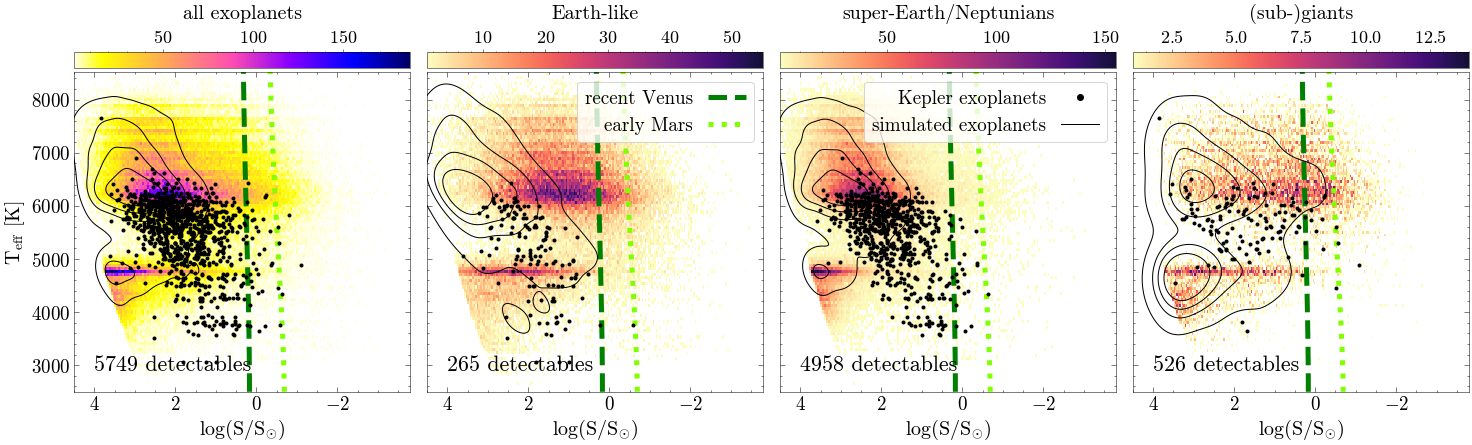

In [ ]:
### test en utilisant masse to classify simulated exopl
fs=20
### same but compare distrib od ! planetary types...

obs_plnts_rad = pd.concat([det_pl_ONLYrad, det_pl_radANDmass])
obs_plnts_mass = det_pl_ONLYmass

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(25,7), sharex=True, sharey=True, gridspec_kw={'width_ratios': [0.8, 0.8, 0.8, 0.8]})
plt.subplots_adjust(wspace=0.05)
step = 1
teff_range = np.linspace(2500, st_kepler.teff.max(), 100)

### all stars
col1 = ax0.hist2d(np.log10(pl_kepler[pl_kepler['in_st_obs']==True].dropna(subset='insolation')['insolation'][::step].astype(float)), 
                  pl_kepler[pl_kepler['in_st_obs']==True].dropna(subset='insolation')['teff_star'][::step], 
           bins=(200, 100), cmap=new_gnuplot2r, density=False, cmin=0.1, rasterized=True)

### plot the recent Venus and early Mars boundaries
ax0.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[0]), teff_range, '--', c='green', 
         label='recent Venus', lw=5)
ax0.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[1]), teff_range, ':', c='chartreuse', 
         label='early Mars', lw=5)

### plot the detectable exopl
sb.kdeplot(data=pl_detect, x='log_insolation', y='teff_star', ax=ax0, color="k", levels=5)
ax0.text(x=4, y=2900, s='%s detectables'%(str(len(pl_detect))), fontsize=fs+2)
ax0.plot(det_kepler['log_insolation'].values, det_kepler['st_teff'].values, '.', c='k')


planetary_types = ['Earth-like', 'super-Earth/Neptunians', '(sub-)giants']
axes = [ax1, ax2, ax3]
min_cut = [10, 10, 10]
cat_cut_rad_obs = [det_kepler["pl_rade"]<limR_Earth_to_SEnept, 
           (det_kepler["pl_rade"]<limR_SEnept_to_giants) & (det_kepler["pl_rade"]>=limR_Earth_to_SEnept), 
           det_kepler["pl_rade"]>=limR_SEnept_to_giants]

cat_cut_mass_simu = [pl_kepler['mass_planet']<limM_Earth_to_SEnept, 
                     (pl_kepler['mass_planet']<limM_SEnept_to_giants) & (pl_kepler['mass_planet']>=limM_Earth_to_SEnept), 
                     pl_kepler['mass_planet']>=limM_SEnept_to_giants]
cat_cut_mass_simu_det = [pl_detect['mass_planet']<limM_Earth_to_SEnept, 
                     (pl_detect['mass_planet']<limM_SEnept_to_giants) & (pl_detect['mass_planet']>=limM_Earth_to_SEnept), 
                     pl_detect['mass_planet']>=limM_SEnept_to_giants]

labels_legends = [['recent Venus', 'early Mars', None, None],
                  [None, None, 'Kepler exoplanets', 'simulated exoplanets'],
                  [None, None, None, None],
                  [None, None, None, None]]

for cat in range(3):
    ax = axes[cat]
    
    plnts_plt = pl_kepler[cat_cut_mass_simu[cat]]
    plnts_det_plt = pl_detect[cat_cut_mass_simu_det[cat]]
    obs_plnts_rad_cat = det_kepler[cat_cut_rad_obs[cat]]

    col = ax.hist2d(np.log10(plnts_plt[plnts_plt['in_st_obs']==True]['insolation'][::step].astype(float)), 
                    plnts_plt[plnts_plt['in_st_obs']==True]['teff_star'][::step], 
           bins=(200, 100), cmap=new_magmar, cmin=0.1, density=False, rasterized=True)#, cmin=min_cut[cat]) #vmin=0, vmax=col1[3].get_clim()[1], cmin=10) #, vmax=0.0005)#, norm=colors.LogNorm()) vmax=0.0004 #, vmin=0, vmax=100000)

    ### plot the recent Venus and early Mars boundaries
    ax.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[0]), teff_range, '--', c='green', 
            label=labels_legends[cat][0], lw=5)
    ax.plot(np.log10(UTILS.calculateEffectiveFluxBoundary_plot(teff_range)[1]), teff_range, ':', c='chartreuse', 
            label=labels_legends[cat][1], lw=5)

    handle_point, = ax.plot(obs_plnts_rad_cat['log_insolation'].values, obs_plnts_rad_cat['st_teff'].values, '.', c='k', label=labels_legends[cat][2])
    sb.kdeplot(data=plnts_det_plt, x='log_insolation', y='teff_star', ax=ax, color="k", levels=5, label=labels_legends[cat][3])
    ax.text(x=4, y=2900, s='%s detectables'%(str(len(plnts_det_plt))), fontsize=fs+2)
    
    ax.set_xlim([3, -2])
    ax.set_ylim([2500, teff_range.max()])
    ax.set_xlabel(r'log(S/S$_{\odot}$)', fontsize=fs)

    ax.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
    ax.tick_params(axis='both', which='minor', length=2)
    ### color bar
    if cat == 0:
        cbar = fig.colorbar(col[3], ax=ax, location='top', pad=0.01)
    else:
        cbar = fig.colorbar(col[3], ax=ax, location='top', pad=0.01)
    cbar.set_label(planetary_types[cat], fontsize=fs, labelpad = 10)
    cbar.ax.tick_params(labelsize=fs-2, which='both', direction='out')
    

cbar0 = fig.colorbar(col1[3], ax=ax0, location='top', pad=0.01)

ax0.set_xlim((4.5, -3.8))
ax0.set_ylabel(r'T$_{\rm eff}$ [K]', fontsize=fs)

ax0.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
ax0.tick_params(axis='both', which='minor', length=2)

ax0.set_xlabel(r'log(S/S$_{\odot}$)', fontsize=fs)

cbar0.set_label('all exoplanets', fontsize=fs, labelpad = 10)
cbar0.ax.tick_params(labelsize=fs-2, which='both', direction='out')

ax1.legend(fontsize=fs-1, loc='upper right', frameon=True, markerfirst=False)
ax2.legend(fontsize=fs-1, loc='upper right', frameon=True, markerfirst=False, markerscale=2)
handles = [handle_point, lines.Line2D([0], [0], color='k')]
labels = [labels_legends[1][2], labels_legends[1][3]]
ax2.legend(handles, labels, fontsize=fs-1, loc='upper right', frameon=True, markerfirst=False, markerscale=2)
#plt.savefig("figures/HZ_limits_density_comparison_Kepler_simu_detected_bettertypeseparation_11agost25.pdf", bbox_inches='tight')

plt.show()

# Fig.10: exoplanets properties in Kepler field (M-R vs P)

(run previous plot preparation cells)

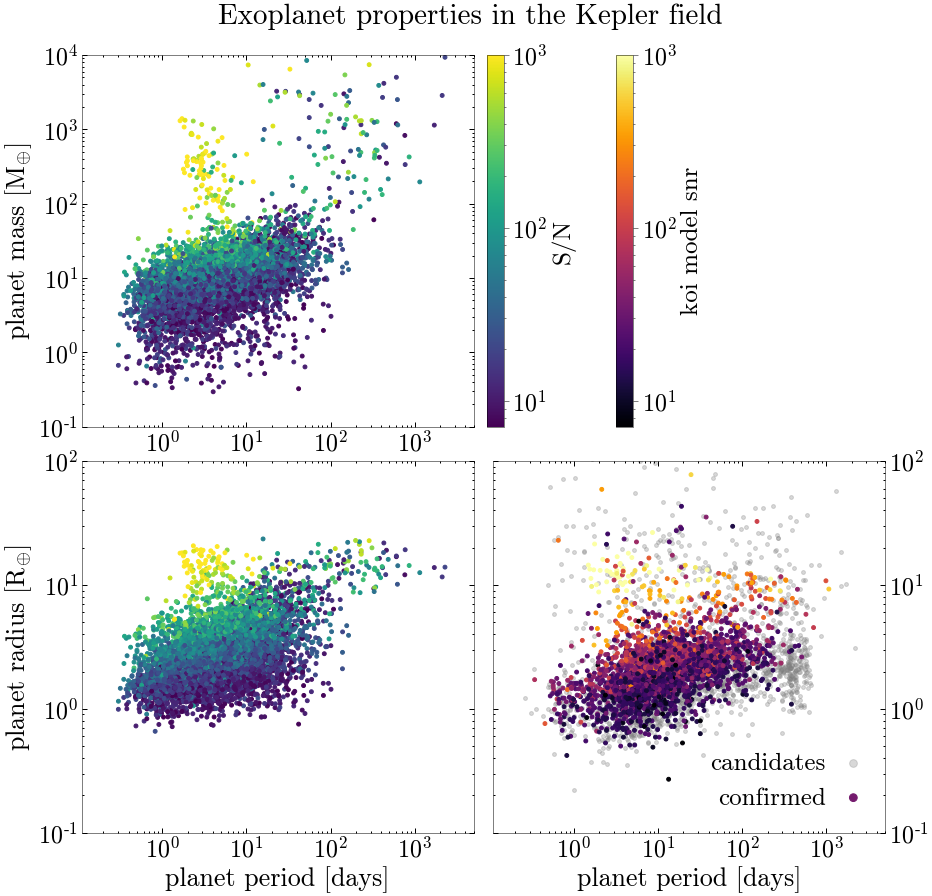

In [ ]:
fs=26
fig = plt.figure(figsize=(12, 12))

gs1 = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.98, top=0.95, bottom=0.52,
                       wspace=0.05)
gs2 = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.98, top=0.48, bottom=0.05,
                       wspace=0.05)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs2[0, 0], sharex=ax1)
ax3 = fig.add_subplot(gs2[0, 1], sharex=ax2, sharey=ax2)

col = ax1.scatter(pl_detect["period_planet"], pl_detect["mass_planet"], 
                 c=pl_detect['SNR'], norm=colors.LogNorm(vmax=1000), s=15, rasterized=True)

col2 = ax2.scatter(pl_detect["period_planet"], pl_detect["radius_planet"], 
                 c=pl_detect['SNR'], norm=colors.LogNorm(vmax=1000), s=15, rasterized=True)

ax3.scatter(exopl_kepler[filter_candidate]['koi_period'], exopl_kepler[filter_candidate]['koi_prad'],
            c='grey', s=15, alpha=0.3, label='candidates', rasterized=True)
col3 = ax3.scatter(exopl_kepler[filter_confirmed]["koi_period"], exopl_kepler[filter_confirmed]["koi_prad"], 
                 c=exopl_kepler[filter_confirmed]['koi_model_snr'], norm=colors.LogNorm(vmin=7.1, vmax=1000), s=15,
                 cmap='inferno', label='confirmed', rasterized=True)

[[x10,y10],[x11,y11]] = ax1.get_position().get_points()
pad = 0.015; width = 0.02
cbar_ax = fig.add_axes([x11+pad, y10, width, (y11-y10)])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(col, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fs-2, which='both', direction='out')
cbar_ax.tick_params(which='major', length=5)
cbar_ax.tick_params(which='minor', length=2)
cbar.set_label('S/N', fontsize=fs-1)

cbar2_ax = fig.add_axes([x11+pad+0.15, y10, width, (y11-y10)])
cbar2_ax.yaxis.set_ticks_position('right')
cbar2 = fig.colorbar(col3, cax=cbar2_ax) 
cbar2_ax.tick_params(labelsize=fs-2, which='both', direction='out')
cbar2_ax.tick_params(which='major', length=5)
cbar2_ax.tick_params(which='minor', length=2)
cbar2.set_label("koi model snr", fontsize=fs-1)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlim(0.11, 5e3)
ax1.set_ylim(0.1, 1e4)
ax2.set_ylim(0.1, 1e2)

ax1.tick_params(axis='both', which='both', labelsize=fs-2, right=True, top=True, direction='in')
ax2.tick_params(axis='both', which='both', labelsize=fs-2, right=True, top=True, direction='in')
ax3.tick_params(axis='both', which='both', labelsize=fs-2, right=True, top=True, direction='in',
                labelleft=False, labelright=True)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', length=5, width=1)
    ax.tick_params(axis='both', which='minor', length=2, width=1)

ax1.set_ylabel(r'planet mass [$\rm M_{\oplus}$]', fontsize=fs)
ax2.set_xlabel('planet period [days]', fontsize=fs)
ax2.set_ylabel(r'planet radius [$\rm R_{\oplus}$]', fontsize=fs)
ax3.set_xlabel('planet period [days]', fontsize=fs)

ax3.legend(loc='lower right', bbox_to_anchor=(1.04, 0.0025), fontsize=fs-1, 
           markerfirst=False, markerscale=2, handletextpad=0.1)

fig.suptitle("Exoplanet properties in the Kepler field", fontsize=fs+3, y=1.01)

#plt.savefig("./figures/M_or_R_vs period_planets_coloredSNR_14juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig. 11: summary plot, comparison 8 regions

### upper left panel: galactic view, positions

In [2]:
g755 = Table.read("./data/plots_files/7.55e11.01024_stars_rsphmax25.0_newcoords.parquet").to_pandas()


In [5]:
### coarse precut to select particles:
# param = [rmin_kpc, rmax_kpc, zmax_abs, phimin_deg, phimax_deg]
# SN
param_sp_SN = [7.7, 8.7, 0.5, 175, 185]
# outer part
param_sp_out = [14, 16, 1.0, 175, 185]
# inner part
param_sp_in = [3.8, 4.2, 0.3, 175, 185]
# galactic center
param_sp_center = [0.07, 0.07] # [Rmax, zmax]
# Rsun but higher z
param_sp_up = [7.5, 8.9, 2.5, 4.0, 165, 195] # [rmin_kpc, rmax_kpc, zmin, zmax, phimin_deg, phimax_deg]
# Rsun but lower z
param_sp_down = [7.5, 8.9, -4.0, -2.5, 165, 195] #  [rmin_kpc, rmax_kpc, zmin, zmax, phimin_deg, phimax_deg]
# phi60
param_sp_60 = [7.7, 8.7, 0.5, 55, 65]
# phi300
param_sp_300 = [7.7, 8.7, 0.5, 295, 305]

mask_SN = (g755['r'] > param_sp_SN[0]) & (g755['r'] < param_sp_SN[1]) & (abs(g755['z']) < param_sp_SN[2]) \
          &(g755['phi_new'] > param_sp_SN[3]) & (g755['phi_new'] < param_sp_SN[4])
mask_outer = (g755['r'] > param_sp_out[0]) & (g755['r'] < param_sp_out[1]) & (abs(g755['z']) < param_sp_out[2])\
          &(g755['phi_new'] > param_sp_out[3]) & (g755['phi_new'] < param_sp_out[4])
mask_inner = (g755['r'] > param_sp_in[0]) & (g755['r'] < param_sp_in[1]) & (abs(g755['z']) < param_sp_in[2])\
          &(g755['phi_new'] > param_sp_in[3]) & (g755['phi_new'] < param_sp_in[4])
mask_center = (g755['r'] < param_sp_center[0]) & (abs(g755['z']) < param_sp_center[1])
mask_upper = (g755['r'] > param_sp_up[0]) & (g755['r'] < param_sp_up[1]) & (g755['z'] > param_sp_up[2]) & (g755['z'] < param_sp_up[3])\
          &(g755['phi_new'] > param_sp_up[4]) & (g755['phi_new'] < param_sp_up[5])
mask_lower = (g755['r'] > param_sp_down[0]) & (g755['r'] < param_sp_down[1]) & (g755['z'] > param_sp_down[2]) & (g755['z'] < param_sp_down[3])\
          &(g755['phi_new'] > param_sp_down[4]) & (g755['phi_new'] < param_sp_down[5])
mask_phi60 = (g755['r'] > param_sp_60[0]) & (g755['r'] < param_sp_60[1]) & (abs(g755['z']) < param_sp_60[2])\
          &(g755['phi_new'] > param_sp_60[3]) & (g755['phi_new'] < param_sp_60[4])
mask_phi300 = (g755['r'] > param_sp_300[0]) & (g755['r'] < param_sp_300[1]) & (abs(g755['z']) < param_sp_300[2])\
          &(g755['phi_new'] > param_sp_300[3]) & (g755['phi_new'] < param_sp_300[4])

labels_regions = ['SN', 'outer', 'inner', 'center', 'phi60', 'phi300', 'upper', 'lower']
masks_reg = [mask_SN, mask_outer, mask_inner, mask_center, mask_phi60, mask_phi300, mask_upper, mask_lower]

def select_sp_reg(mask):
    return g755[mask]

collist = ['#44AA99', '#88CCEE', '#117733', '#332288', '#999933', '#DDCC77', '#CC6677', '#882255']

legend_elements = []
for i in range(len(collist)):
    legend_elements.append(Patch(facecolor=collist[i], edgecolor=collist[i], label=labels_regions[i]))

### upper right panel: HRd

### lower left panel: stellar parameters

In [6]:
labels_regions = ['SN', 'outer', 'inner', 'center', 'phi60', 'phi300', 'upper', 'lower']
labels_regions_part1 = ['SN', 'outer', 'inner', 'center', None, None, None, None]
labels_regions_part2 = [None, None, None, None, 'phi60', 'phi300', 'upper', 'lower']
fechas_regions = ['25juliol24', '02oct24', '02oct24', '03oct24', '04oct24', '04oct24', '03oct24', '03oct24']

def read_stars(sample_name, fecha):
    st_df = pd.read_parquet("data/plots_files/%s_755e11_SINGLES_and_PLANETSstats_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha))
    return st_df

### lower right panel: occ rate != planet types

In [7]:
limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

labels_regions = ['SN', 'outer', 'inner', 'center', 'phi60', 'phi300',
                'upper', 'lower']
fechas_regions = ['25juliol24', '02oct24', '02oct24', '03oct24', '04oct24', '04oct24',
                '03oct24', '03oct24']

def read_planets(sample_name, fecha):
    pl_df = pd.read_parquet("data/plots_files/%s_755e11_PLANETS_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha))
    return pl_df

def save_nb_tot_stars(sample_name, fecha):
    df_st = pd.read_parquet("data/%s_755e11_SINGLES_and_PLANETSstats_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha)) 
    nb_stars = len(df_st)
    del df_st
    return nb_stars
    
r = np.arange(0, len(labels_regions))

list_nb_all_stars = []
for i in range(len(labels_regions)):
    list_nb_all_stars.append(save_nb_tot_stars(labels_regions[i], fechas_regions[i]))

# Values of each group
bars_EL = []
bars_SE = []
bars_G = []
EL_perc = []
SE_perc = []
G_perc = []

for i in tqdm(range(len(labels_regions))):
    reg = read_planets(labels_regions[i], fechas_regions[i])
    nb_stars = list_nb_all_stars[i]
    nb_tot_pl = len(reg)
    bars_EL.append(len(reg[reg['mass_planet']<limM_Earth_to_SEnept])/nb_stars)
    bars_SE.append(len(reg[(reg['mass_planet']>=limM_Earth_to_SEnept) & (reg['mass_planet']<limM_SEnept_to_giants)])/nb_stars)
    bars_G.append(len(reg[reg['mass_planet']>=limM_SEnept_to_giants])/nb_stars)
    EL_perc.append(str(np.round(len(reg[reg['mass_planet']<limM_Earth_to_SEnept])/nb_tot_pl*100, 1))+'%')
    SE_perc.append(str(np.round(len(reg[(reg['mass_planet']>=limM_Earth_to_SEnept) & (reg['mass_planet']<limM_SEnept_to_giants)])/nb_tot_pl*100, 1))+'%')
    G_perc.append(str(np.round(len(reg[reg['mass_planet']>=limM_SEnept_to_giants])/nb_tot_pl*100, 1))+'%')

# Heights of bars1 + bars2
bars = np.add(bars_EL, bars_SE).tolist()

100%|█████████████████████████████████████████████| 8/8 [00:38<00:00,  4.83s/it]


In [8]:
def x_label_panel(ax, pos='left'):
    if pos == 'left': side = 0.05
    else: side = 0.9
    x_coord = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*side
    return x_coord

def y_label_panel(ax):
    y_coord = ax.get_ylim()[1] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.16
    return y_coord

100%|█████████████████████████████████████████████| 8/8 [06:41<00:00, 50.21s/it]


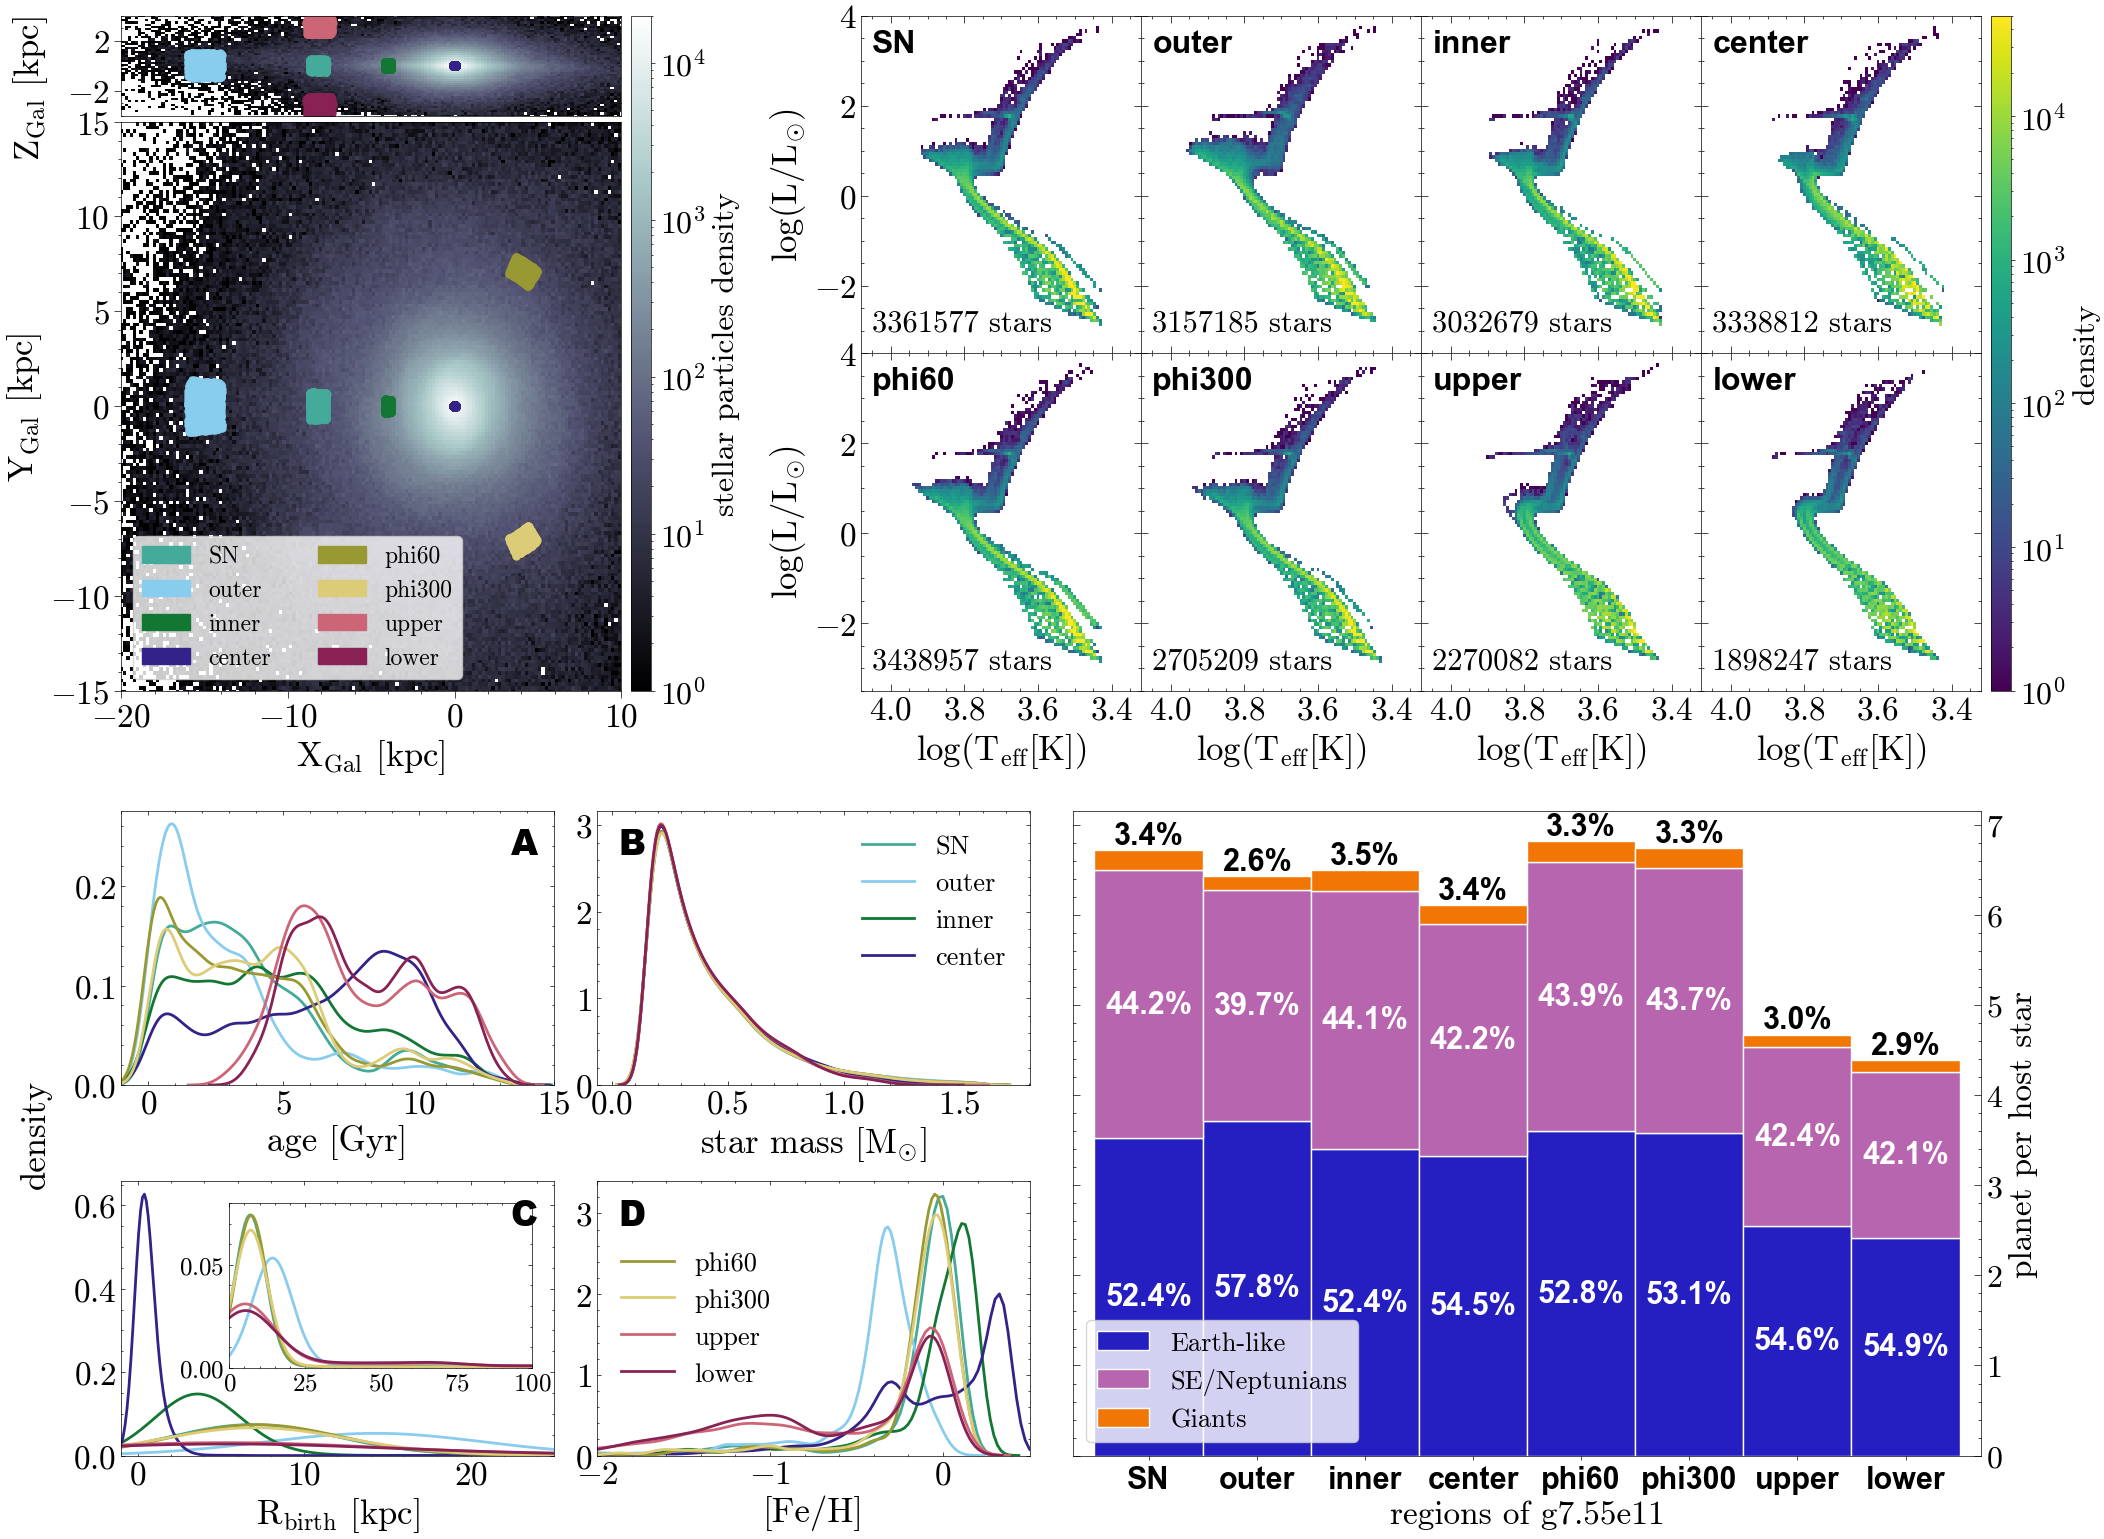

In [9]:
### all-in-one plot
fs=25
fig = plt.figure(figsize=(20, 15)) 
###################################################
#################### STRUCTURE ####################
###################################################
gs0 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.3, top=0.98, bottom=0.53,
                        wspace=0.1)
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.42, right=0.98, top=0.98, bottom=0.53,
                        wspace=0.0, hspace=0.0)
ax0 = fig.add_subplot(gs0[:, :])

axes = []
for i in range(len(labels_regions)):
    if i == 0:
        ax = fig.add_subplot(gs1[i//4, i-(i//4)*4])
        axes.append(ax)
    else:
        ax = fig.add_subplot(gs1[i//4, i-(i//4)*4], sharex=axes[0], sharey=axes[0])
        axes.append(ax)

gs2 = fig.add_gridspec(nrows=2, ncols=4, left=0.05, right=0.98, top=0.45, bottom=0.02,
                        wspace=0.1, hspace=0.35)
ax1 = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[0, 1])
ax3 = fig.add_subplot(gs2[1, 0])
ax4 = fig.add_subplot(gs2[1, 1])

ax_occ = fig.add_subplot(gs2[:, 2:])#, sharey=ax4)
###################################################
####################### DATA ######################
###################################################

###################################################
############ position
vmin_dens = 1
vmax_dens = 20000

divider = make_axes_locatable(ax0)
axtop = divider.append_axes('top', 1.0, sharex=ax0, pad=0.06)
axtop.xaxis.set_visible(False)

[[x10,y10],[x11,y11]] = ax0.get_position().get_points()
[[x10t,y10t],[x11t,y11t]] = axtop.get_position().get_points()

### density entire galaxy
c1 = ax0.hist2d(g755["x_gal"][(abs(g755['z']) < 0.5)], g755["y_gal"][(abs(g755['z']) < 0.5)], 
           bins=(250, 250), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

axtop.hist2d(g755["x_gal"][(abs(g755['y_gal']) < 0.5)], g755["z"][(abs(g755['y_gal']) < 0.5)], 
           bins=(250, 50), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

### stellar particles selections
for i in range(len(labels_regions)):
    reg_sp = select_sp_reg(masks_reg[i])
    if i < 4: # top and edge on views
        ax0.plot(reg_sp["x_gal"], reg_sp["y_gal"], '.', ms=10, c=collist[i], label=labels_regions[i], rasterized=True)
        axtop.plot(reg_sp["x_gal"], reg_sp["z"], '.', ms=10, c=collist[i], rasterized=True)
    elif i < 6: # only top view
        ax0.plot(reg_sp["x_gal"], reg_sp["y_gal"], '.', ms=10, c=collist[i], label=labels_regions[i], rasterized=True)
    else: # only edge on view
        axtop.plot(reg_sp["x_gal"], reg_sp["z"], '.', ms=10, c=collist[i], rasterized=True)

axtop.set_ylabel(r"$\rm Z_{\rm Gal}$ [kpc]", labelpad=12, fontsize=fs, loc='top')
axtop.set_xlim([-20, 10])
axtop.set_ylim([-4, 4])
axtop.set_yticks([-2, 2])
axtop.tick_params(axis='x', labelsize=fs-1)
axtop.tick_params(axis='y', which='major', labelsize=fs-1, direction='out', length=5, right=False)

ax0.set_xlim([-20, 10])
ax0.set_ylim([-15, 15])
ax0.set_xlabel(r"$\rm X_{\rm Gal}$ [kpc]", fontsize=fs)
ax0.set_ylabel(r"$\rm Y_{\rm Gal}$ [kpc]", fontsize=fs)
ax0.tick_params(axis='both', which='major', labelsize=fs-1, direction='out', length=5, right=False, top=False)
ax0.tick_params(axis='both', which='minor', direction='out', length=2, right=False, top=False)

ax0.legend(handles=legend_elements, ncol=2, fontsize=fs-8, loc='lower left', frameon=True)

cbar_ax = fig.add_axes([x11+0.005, y10, 0.01, y11t-y10])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(c1[3], cax=cbar_ax)
cbar.set_label('stellar particles density', fontsize=fs-2)
cbar_ax.tick_params(axis='both', which='both', labelsize=fs-2, direction='out')

###################################################
############ HRd
for i in tqdm(range(len(labels_regions))):
    reg = read_stars(labels_regions[i], fechas_regions[i])
    if i == 0:
        c1 = axes[i].hist2d(reg['logTe'], reg['logl'],
                bins=(np.linspace(3.32, 4.08, 100), np.linspace(-3.5, 4, 100)), 
                cmap='viridis', norm=colors.LogNorm(vmax=5e4), cmin=0.1, rasterized=True)
    else:
        axes[i].hist2d(reg['logTe'], reg['logl'],
                bins=(np.linspace(3.32, 4.08, 100), np.linspace(-3.5, 4, 100)), 
                cmap='viridis', norm=colors.LogNorm(vmax=5e4), cmin=0.1, rasterized=True)
    axes[i].text(4.05, -3, str(len(reg))+' stars', fontsize=fs-3)
    axes[i].text(4.05, 3.2, labels_regions[i], fontsize=fs-2, fontname='Arial', weight='bold')

    if i//4 == 1:
        axes[i].set_xlabel(r'$\log(\rm T_{eff} [K])$', fontsize=fs)
        axes[i].tick_params(axis='x', direction='in', top=True)
        axes[i].xaxis.set_ticks([4.0, 3.8, 3.6, 3.4])
        
    else: 
        axes[i].tick_params(axis='x', direction='in', top=True, labelbottom=False, labeltop=False)

    if i-(i//4)*4 == 0:
        axes[i].set_ylabel(r'$\log(\rm L/L_{\odot})$', fontsize=fs)
        axes[i].tick_params(axis='y', direction='in', right=True)
    else:
        axes[i].tick_params(axis='y', direction='in', right=True, labelright=False, labelleft=False)

    axes[i].tick_params(axis='both', which='major', labelsize=fs-1, length=5)
    axes[i].tick_params(axis='both', which='minor', length=2)

axes[0].axis([4.08, 3.32, -3.5, 4])

[[x10,y10],[x11,y11]] = axes[-1].get_position().get_points()
[[x00,y00],[x01,y01]] = axes[3].get_position().get_points()
pad = 0.005; width = 0.01
cbar_ax = fig.add_axes([x11+pad, y10, width,(y01-y10)])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(c1[3], cax=cbar_ax)
cbar_ax.tick_params(axis='both', which='both', labelsize=fs-2, direction='out')


cbar.set_label('density', fontsize=fs-2)

###################################################
############ kde, stellar params
bw=3
### add zom-out for Rbirth
axins = ax3.inset_axes([0.25, 0.32, 0.7, 0.6], 
                        xlim=(0, 100), ylim=(0, 0.08)) 

i = 0
for i in tqdm(range(len(labels_regions))):
    reg = read_stars(labels_regions[i], fechas_regions[i])
    sb.kdeplot(data=reg['age'].values, ax=ax1, bw_adjust=bw, cut=3,
             lw=2, color=collist[i])
    sb.kdeplot(data=reg['mass_star_rvs'].values, ax=ax2, bw_adjust=bw, cut=3,
            lw=2, color=collist[i], label=labels_regions_part1[i])
    sb.kdeplot(data=reg['rbirth'].values, ax=ax3, bw_adjust=bw, gridsize=500, cut=3, clip=(-1, 100),
             lw=2, color=collist[i])
    sb.kdeplot(data=reg['feh'].values, ax=ax4, bw_adjust=bw, cut=3,
             lw=2, color=collist[i], label=labels_regions_part2[i])

    if (labels_regions[i] != 'center') & (labels_regions[i] != 'inner'):
        sb.kdeplot(data=reg['rbirth'], ax=axins, bw_adjust=bw, gridsize=500, cut=3, clip=(-1, 100),
             lw=2, color=collist[i])

    i += 1

### axes
ax1.set_xlabel("age [Gyr]", fontsize=fs)
ax3.set_xlabel(r"$\rm R_{\rm birth}$ [kpc]", fontsize=fs)
ax2.set_xlabel(r"star mass [$\rm M_{\odot}$]", fontsize=fs)
ax4.set_xlabel("[Fe/H]", fontsize=fs)

ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax3.set_ylabel(None)
ax4.set_ylabel(None)

ax_group = fig.add_subplot(gs2[:, 0])
ax_group.set_xticks([])
ax_group.set_yticks([])
ax_group.set_frame_on(False)
ax_group.set_ylabel("density", fontsize=fs, labelpad=50)

axins.set_xlabel(None)
axins.set_ylabel(None)
axins.tick_params(labelsize=fs-7)

ax1.set_xlim((-1, 15))
ax3.set_xlim((-1, 25))
ax4.set_xlim((-2, 0.5)) 
ax1.tick_params(axis='both', which='major', labelsize=fs-1)
ax2.tick_params(axis='both', which='major', labelsize=fs-1)
ax3.tick_params(axis='both', which='major', labelsize=fs-1)
ax4.tick_params(axis='both', which='major', labelsize=fs-1)
ax2.legend(fontsize=fs-6, loc='upper right')
ax4.legend(fontsize=fs-6, loc='center left')

ax1.text(x_label_panel(ax1, pos='right'), y_label_panel(ax1), "A", fontsize=fs, fontname='Arial Black')
ax2.text(x_label_panel(ax2, pos='left'), y_label_panel(ax2), "B", fontsize=fs, fontname='Arial Black')
ax3.text(x_label_panel(ax3, pos='right'), y_label_panel(ax3), "C", fontsize=fs, zorder=10, fontname='Arial Black')
ax4.text(x_label_panel(ax4, pos='left'), y_label_panel(ax4), "D", fontsize=fs, fontname='Arial Black')

###################################################
############ OCC RATE pl types
barWidth = 1
p1 = ax_occ.bar(r, bars_EL, color='#251FC1', edgecolor='white', width=barWidth, label='Earth-like')
p2 = ax_occ.bar(r, bars_SE, bottom=bars_EL, color='#B865AF', edgecolor='white', width=barWidth, label='SE/Neptunians')
p3 = ax_occ.bar(r, bars_G, bottom=bars, color='#F17604', edgecolor='white', width=barWidth, label='Giants')

# Custom X axis
ax_occ.set_xticks(r, labels_regions, fontname='Arial', weight='bold', fontsize=fs-3)
ax_occ.tick_params(axis='y', which='major', labelsize=fs-2, length=5)
ax_occ.tick_params(axis='y', which='minor', length=2)
ax_occ.set_xlabel("regions of g7.55e11", fontsize=fs-1)

ax_occ.bar_label(p1, labels=EL_perc, label_type='center', color='white', fontname='Arial', weight="bold", fontsize=fs-3)
ax_occ.bar_label(p2, labels=SE_perc, label_type='center', color='white', fontname='Arial', weight="bold", fontsize=fs-3)
ax_occ.bar_label(p3, labels=G_perc, label_type='edge', fontname='Arial', padding=0, color='k', weight="bold", fontsize=fs-3)
ax_occ.set_ylabel('planet per host star', fontsize=fs-1)
ax_occ.yaxis.set_label_position("right")
ax_occ.tick_params(axis='y', direction='in', right=True, labelright=True, labelleft=False)
ax_occ.tick_params(axis='x', direction='out', top=False)
ax_occ.xaxis.minorticks_off()
ax_occ.legend(loc='lower left', fontsize=fs-6, frameon=True)
ax_occ.set_xlim(-0.7, 7.7)

#plt.savefig("./figures/all-in-one_plot_comparison_8reg_14juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig.12: summary plot, comparison SN in 6 galaxies

### upper panels: positions in glx

In [17]:
labels_fullglxs = ['6.96e11', '7.08e11', '8.26e11', '1.12e12', '2.79e12']
colors_fullglxs = ['#6699CC', '#004488', '#EECC66','#EE99AA', '#994455']

def read_fullglx(sample_name):
    if (sample_name == '6.96e11') or (sample_name == '7.08e11') or (sample_name == '7.55e11'): snapshot_nb = '01024'
    else: snapshot_nb = '02000'
    glx = Table.read('data/plots_files/%s.%s_stars_rsphmax25.0.fits'%(sample_name, snapshot_nb))

    rotgal = +30.
    glx['x_gal'] = +glx['x'] * np.cos(np.deg2rad(rotgal)) - glx['y'] * np.sin(np.deg2rad(rotgal))
    glx['y_gal'] = +glx['x'] * np.sin(np.deg2rad(rotgal)) + glx['y'] * np.cos(np.deg2rad(rotgal))
    glx['phi_gal'] = np.rad2deg(np.arctan2(-glx['y_gal'], glx['x_gal']))

    # rotate the frame by -60 deg and flip the angular-momentum vector
    rotation = -60.
    glx['x_new'] = -glx['x'] * np.cos(np.deg2rad(rotation)) + glx['y'] * np.sin(np.deg2rad(rotation))
    glx['y_new'] = +glx['x'] * np.sin(np.deg2rad(rotation)) + glx['y'] * np.cos(np.deg2rad(rotation))
    glx['phi_new'] = np.rad2deg(np.arctan2(glx['x_new'], glx['y_new'])) + 180.
    
    glx['r'] = np.sqrt(glx['x']**2. + glx['y']**2)

    return glx

### lower left: stellar properties (KDE)

In [18]:
labels_glxs = ['6.96e11', '7.08e11', '7.55e11', '8.26e11', '1.12e12', '2.79e12']
labels_glxs_file = ['696e11', '708e11', '755e11', '826e11', '112e12', '279e12']
fechas_glxs = ['13set24', '15set24', '25juliol24', '15set24', '16set24', '01oct24']
colors_glxs = ['#6699CC', '#004488', '#44AA99', '#EECC66','#EE99AA', '#994455']
labels_glxs_part1 = ['6.96e11', '7.08e11', '7.55e11', None, None, None]
labels_glxs_part2 = [None, None, None, '8.26e11', '1.12e12', '2.79e12']

def read_stars_glx(sample_name, fecha):
    st_df = pd.read_parquet("data/plots_files/SN_%s_SINGLES_and_PLANETSstats_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha))
    return st_df

In [19]:
def x_label_panel(ax, pos='left'):
    if pos == 'left': side = 0.05
    else: side = 0.9
    x_coord = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*side
    return x_coord

def y_label_panel(ax):
    y_coord = ax.get_ylim()[1] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.16
    return y_coord

### lower right: occ rate != planets types

In [20]:
limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

def read_planets_glx(sample_name, fecha):
    pl_df = pd.read_parquet("data/plots_files/SN_%s_PLANETS_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha))
    return pl_df

def save_nb_tot_stars_glx(sample_name, fecha):
    df_st = pd.read_parquet("data/plots_files/SN_%s_SINGLES_and_PLANETSstats_%s_rerun_3mars25_AltMet.parquet"%(sample_name, fecha)) 
    nb_stars = len(df_st)
    del df_st
    return nb_stars

list_nb_all_stars_glx = []
for i in range(len(labels_glxs_file)):
    list_nb_all_stars_glx.append(save_nb_tot_stars_glx(labels_glxs_file[i], fechas_glxs[i]))

In [21]:
# Values of each group
bars_EL = []
bars_SE = []
bars_G = []
EL_perc = []
SE_perc = []
G_perc = []

for i in tqdm(range(len(labels_glxs))):
    glx = read_planets_glx(labels_glxs_file[i], fechas_glxs[i])
    if i == 4:
        scale_fact = 1
    else:
        scale_fact = 1

    nb_stars = list_nb_all_stars_glx[i]
    nb_tot_pl = len(glx)
    bars_EL.append(len(glx[glx['mass_planet']<limM_Earth_to_SEnept])/nb_stars)
    bars_SE.append(len(glx[(glx['mass_planet']>=limM_Earth_to_SEnept) & (glx['mass_planet']<limM_SEnept_to_giants)])/nb_stars)
    bars_G.append(len(glx[glx['mass_planet']>=limM_SEnept_to_giants])/nb_stars)
    EL_perc.append(str(np.round(len(glx[glx['mass_planet']<limM_Earth_to_SEnept])/nb_tot_pl*100, 1))+'%')
    SE_perc.append(str(np.round(len(glx[(glx['mass_planet']>=limM_Earth_to_SEnept) & (glx['mass_planet']<limM_SEnept_to_giants)])/nb_tot_pl*100, 1))+'%')
    G_perc.append(str(np.round(len(glx[glx['mass_planet']>=limM_SEnept_to_giants])/nb_tot_pl*100, 1))+'%')

# Heights of bars1 + bars2
bars = np.add(bars_EL, bars_SE).tolist()
 
# The position of the bars on the x-axis
r = np.arange(0, len(labels_glxs))
 
# Names of group and bar width
names = labels_glxs
barWidth = 1

100%|█████████████████████████████████████████████| 6/6 [05:28<00:00, 54.77s/it]


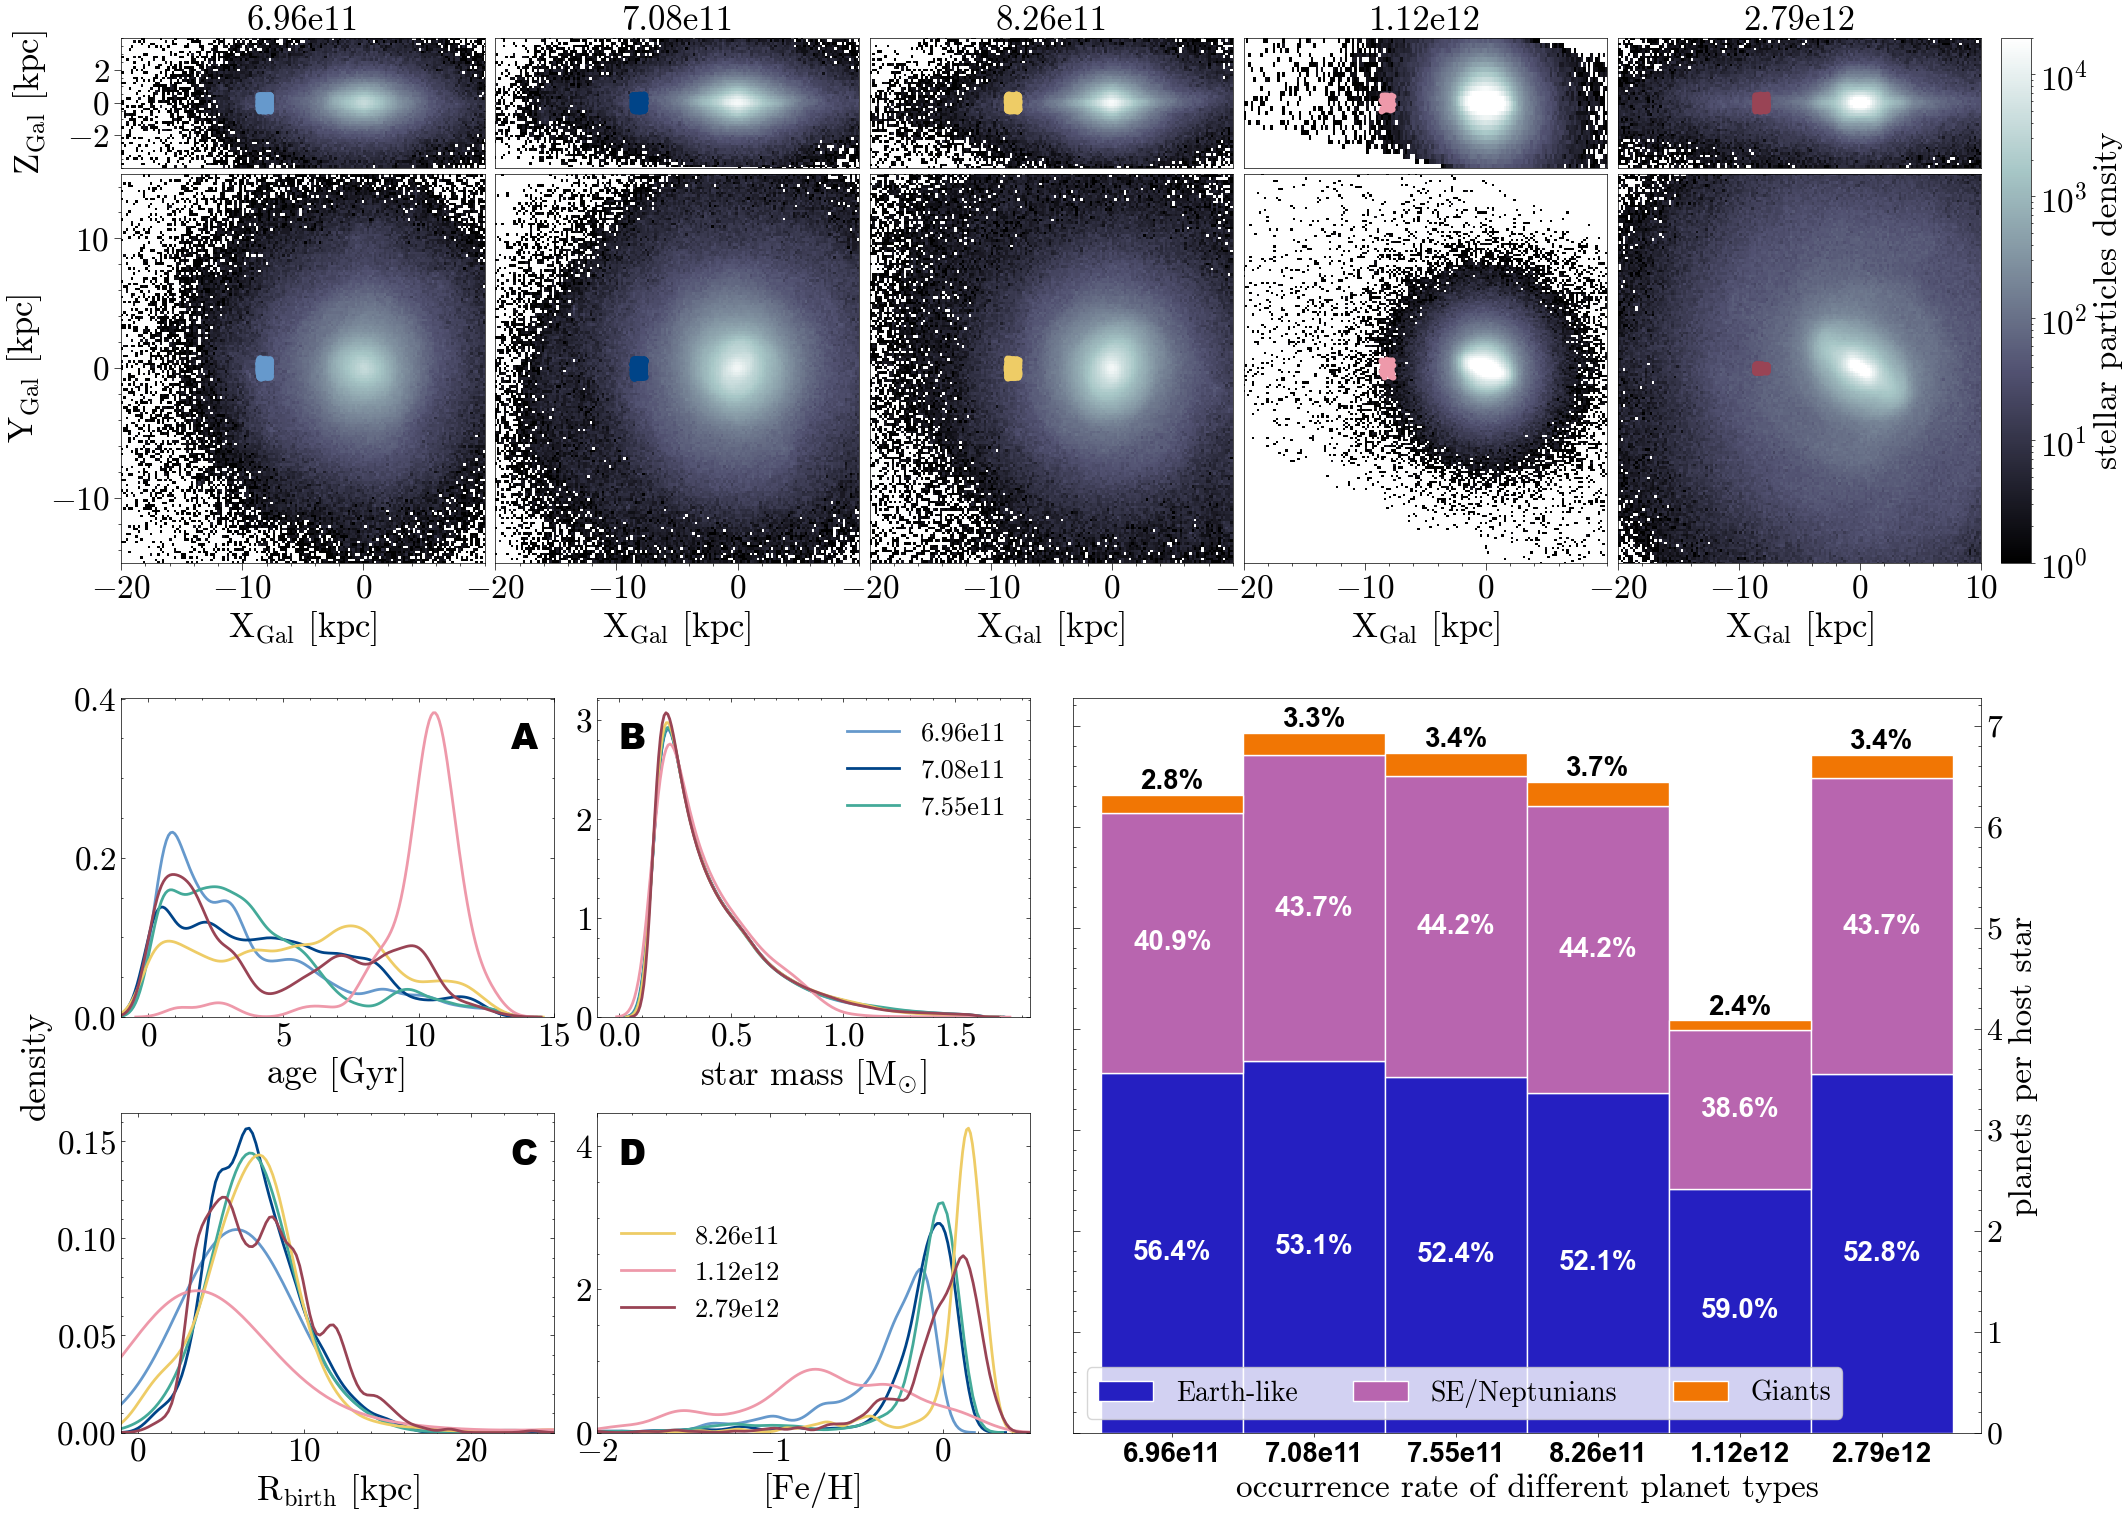

In [22]:
### all-in-one plot
fs=25
fig = plt.figure(figsize=(20, 15)) 
###################################################
#################### STRUCTURE ####################
###################################################
gs1 = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.98, top=0.98, bottom=0.63,
                        wspace=0.03, hspace=0.2)
axes = []
for i in range(len(labels_fullglxs)):
    if i == 0:
        ax = fig.add_subplot(gs1[0, i])
        axes.append(ax)
    else:
        ax = fig.add_subplot(gs1[0, i], sharey=axes[0])
        axes.append(ax)

gs2 = fig.add_gridspec(nrows=2, ncols=4, left=0.05, right=0.98, top=0.54, bottom=0.05,
                        wspace=0.1, hspace=0.3)
ax1 = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[0, 1])
ax3 = fig.add_subplot(gs2[1, 0])
ax4 = fig.add_subplot(gs2[1, 1])

ax_occ = fig.add_subplot(gs2[:, 2:])

###################################################
####################### DATA ######################
###################################################

###################################################
############ position
vmin_dens = 1
vmax_dens = 20000

axtops = [0, 0, 0, 0, 0]
### add top axis
for i in range(len(axes)):
    divider = make_axes_locatable(axes[i])
    axtops[i] = divider.append_axes('top', 1.3, sharex=axes[i], pad=0.06)
    axtops[i].xaxis.set_visible(False)
    axes[i].set_xlim(-20, 10)
    axes[i].set_ylim(-15, 15)

left_ticks = [True, False, False, False, False]
for j in tqdm(range(len(axes))):
    glx = read_fullglx(labels_fullglxs[j])
    ax = axes[j]
    axtop = axtops[j]

    ### plot stellar density
    c1 = ax.hist2d(glx["x_gal"][(abs(glx['z']) < 0.5)], glx["y_gal"][(abs(glx['z']) < 0.5)], 
           bins=(250, 250), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

    axtop.hist2d(glx["x_gal"][(abs(glx['y_gal']) < 0.5)], glx["z"][(abs(glx['y_gal']) < 0.5)], 
           bins=(250, 50), cmap='bone', density=False, 
           norm=colors.LogNorm(vmin=vmin_dens, vmax=vmax_dens), rasterized=True)

    ### plot SN selection
    # SN
    if j != 4: param_sp_SN = [7.7, 8.7, 0.5, 175, 185]
    else: param_sp_SN = [7.7, 8.7, 0.5, 178, 182]

    sp = glx[ (glx['r'] > param_sp_SN[0]) & (glx['r'] < param_sp_SN[1]) & (abs(glx['z']) < param_sp_SN[2])
          &(glx['phi_new'] > param_sp_SN[3]) & (glx['phi_new'] < param_sp_SN[4])].to_pandas()
    
    ax.scatter(sp["x_gal"], sp["y_gal"], s=10, c=colors_fullglxs[j], label=labels_fullglxs[j])
    axtop.scatter(sp["x_gal"], sp["z"], s=10, c=colors_fullglxs[j])
    
    axtop.set_xlim([-20, 10])
    axtop.set_ylim([-4, 4])
    axtop.set_yticks([])
    axtop.tick_params(axis='x', labelsize=fs-1)
    axtop.tick_params(axis='y', which='major', labelsize=fs-1, direction='out', length=5, right=False)

    ax.set_xlim([-20, 10])
    ax.set_ylim([-15, 15])
    if j < 4: ax.set_xticks([-20, -10, 0])
    
    #ax.set_aspect('equal')
    ax.set_xlabel(r"$\rm X_{\rm Gal}$ [kpc]", fontsize=fs)
    ax.tick_params(axis='x', labelsize=fs-1)

    ax.tick_params(axis='both', which='major', labelsize=fs-1, direction='out', length=5, right=False, left=left_ticks[j], top=False, labelleft=left_ticks[j])
    ax.tick_params(axis='both', which='minor', direction='out', length=2, right=False, left=left_ticks[j], top=False, labelleft=left_ticks[j])

    axtop.set_title(labels_fullglxs[j], fontsize=fs)

axes[0].set_ylabel(r"$\rm Y_{\rm Gal}$ [kpc]", fontsize=fs)
axes[0].tick_params(axis='y', labelsize=fs-1)

axtops[0].set_ylabel(r"$\rm Z_{\rm Gal}$ [kpc]", labelpad=12, fontsize=fs)
axtops[0].set_yticks([-2, 0, 2])

[[x10,y10],[x11,y11]] = axes[-1].get_position().get_points()
[[x10t,y10t],[x11t,y11t]] = axtops[-1].get_position().get_points()

cbar_ax = fig.add_axes([x11+0.01, y10, 0.015, y11t-y10])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(c1[3], cax=cbar_ax)
cbar.set_label('stellar particles density', fontsize=fs-1)
cbar_ax.tick_params(axis='both', which='both', labelsize=fs-1, direction='out')

###################################################
############ kde, stellar params
bw=3

i = 0
for i in tqdm(range(len(labels_glxs))):
    glx = read_stars_glx(labels_glxs_file[i], fechas_glxs[i])
    sb.kdeplot(data=glx['age'].values, ax=ax1, bw_adjust=bw, cut=3,
             lw=2, color=colors_glxs[i])
    sb.kdeplot(data=glx['mass_star_rvs'].values, ax=ax2, bw_adjust=bw, cut=3,
            lw=2, color=colors_glxs[i], label=labels_glxs_part1[i])
    sb.kdeplot(data=glx['rbirth'].values, ax=ax3, bw_adjust=1, gridsize=500, cut=3, clip=(-1, 100),
             lw=2, color=colors_glxs[i])
    sb.kdeplot(data=glx['feh'].values, ax=ax4, bw_adjust=bw, cut=3,
             lw=2, color=colors_glxs[i], label=labels_glxs_part2[i])

    i += 1

### axes
ax1.set_xlabel("age [Gyr]", fontsize=fs)
ax3.set_xlabel(r"$\rm R_{\rm birth}$ [kpc]", fontsize=fs)
ax2.set_xlabel(r"star mass [$\rm M_{\odot}$]", fontsize=fs)
ax4.set_xlabel("[Fe/H]", fontsize=fs)

ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax3.set_ylabel(None)
ax4.set_ylabel(None)

ax_group = fig.add_subplot(gs2[:, 0])
ax_group.set_xticks([])
ax_group.set_yticks([])
ax_group.set_frame_on(False)
ax_group.set_ylabel("density", fontsize=fs, labelpad=50)

ax1.set_xlim((-1, 15))
ax3.set_xlim((-1, 25))
ax4.set_xlim((-2, 0.5)) 
ax1.tick_params(axis='both', which='major', labelsize=fs-1)
ax2.tick_params(axis='both', which='major', labelsize=fs-1)
ax3.tick_params(axis='both', which='major', labelsize=fs-1)
ax4.tick_params(axis='both', which='major', labelsize=fs-1)
ax2.legend(fontsize=fs-6, loc='upper right')
ax4.legend(fontsize=fs-6, loc='center left')

ax1.text(x_label_panel(ax1, pos='right'), y_label_panel(ax1), "A", fontsize=fs, fontname='Arial Black')
ax2.text(x_label_panel(ax2, pos='left'), y_label_panel(ax2), "B", fontsize=fs, fontname='Arial Black')
ax3.text(x_label_panel(ax3, pos='right'), y_label_panel(ax3), "C", fontsize=fs, zorder=10, fontname='Arial Black')
ax4.text(x_label_panel(ax4, pos='left'), y_label_panel(ax4), "D", fontsize=fs, fontname='Arial Black')

###################################################
################ Occ rate planet types

# Heights of bars1 + bars2
bars = np.add(bars_EL, bars_SE).tolist()
 
# The position of the bars on the x-axis
r = np.arange(0, len(labels_glxs))
 
# Names of group and bar width
names = labels_glxs
barWidth = 1

p1 = ax_occ.bar(r, bars_EL, color='#251FC1', edgecolor='white', width=barWidth, label='Earth-like')
p2 = ax_occ.bar(r, bars_SE, bottom=bars_EL, color='#B865AF', edgecolor='white', width=barWidth, label='SE/Neptunians')
p3 = ax_occ.bar(r, bars_G, bottom=bars, color='#F17604', edgecolor='white', width=barWidth, label='Giants')

# Custom X axis
ax_occ.set_xticks(r, names, fontname='Arial', weight='bold', fontsize=fs-5)
ax_occ.set_xlabel("occurrence rate of different planet types", fontsize=fs-1)
ax_occ.tick_params(axis='y', which='major', labelsize=fs-2, length=5)
ax_occ.tick_params(axis='y', which='minor', length=2)

ax_occ.bar_label(p1, labels=EL_perc, label_type='center', color='white', fontname='Arial', weight="bold", fontsize=fs-5)
ax_occ.bar_label(p2, labels=SE_perc, label_type='center', color='white', fontname='Arial', weight="bold", fontsize=fs-5)
ax_occ.bar_label(p3, labels=G_perc, label_type='edge', padding=0, color='k', fontname='Arial', weight="bold", fontsize=fs-5)
ax_occ.set_ylabel('planets per host star', fontsize=fs-1)
ax_occ.yaxis.set_label_position("right")
ax_occ.tick_params(axis='y', direction='in', right=True, labelright=True, labelleft=False)
ax_occ.tick_params(axis='x', direction='out', top=False)
ax_occ.tick_params(axis='x', which='minor', top=False, bottom=False)
ax_occ.legend(loc='lower left', fontsize=fs-5, frameon=True, ncol=3)
ax_occ.set_xlim(-0.7, 5.7)

#plt.savefig("./figures/all-in-one_plot_comparison_6glxs_22juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig. A1: planetary syst, examples + architecture occ rate

In [16]:
sample_name = 'SN_755e11'
fecha = '25juliol24_rerun_3mars25_AltMet'
path_saving_planetary_systems = "data/" + sample_name + "_PLANETARY_SYST_" + fecha + ".parquet"
planetary_systems = pd.read_parquet(path_saving_planetary_systems)

In [17]:
def count_stars(ps, stellar_type, architecture_type, norm_sttype=False, norm=False):
    list_sttypes = ['F', 'G', 'K', 'M', 'all']
    ii = list_sttypes.index(stellar_type)
    temps_inf = [6000, 5200, 3700, 0, 0]
    temps_sup = [7500, 6000, 5200, 3700, 7500]
    # selection by architecture syst
    if architecture_type != 'all':
        sel_arch = ps[ps['plsyst_type']==architecture_type]
    else:
        sel_arch = ps
    # selection by stellar type
    if stellar_type == 'all':
        sel_sttype = sel_arch
    else: 
        sel_sttype = sel_arch[ (sel_arch["teff_star"]>=temps_inf[ii]) & (sel_arch["teff_star"]<temps_sup[ii])]
        
    if norm:
        res = len(sel_sttype)/len(ps)
    elif norm_sttype:
        res = len(sel_sttype) / len(ps[ (ps['teff_star']>=temps_inf[ii]) & (ps['teff_star']<temps_sup[ii]) ])
    else: 
        res = len(sel_sttype)
    
    return res*100

In [ ]:
c_earth = "#251FC1"
c_SEn = "#B865AF"
c_giants = "#F17604"

limR_Earth_to_SEnept = 1.25
limR_SEnept_to_giants = 4
limM_Earth_to_SEnept = 2
limM_SEnept_to_giants = 30

### compare histograms for ! stellar types
arch_types = ("Similar", "Antiordered", "Ordered", "Mixed")

counts_normsttype = {
    'Mishra+23': (80.2835, 8.1186, 1.1598, 7.8608),
    'simulation': (count_stars(planetary_systems, 'all', 'Similar', norm_sttype=True), count_stars(planetary_systems, 'all', 'Antiordered', norm_sttype=True), 
            count_stars(planetary_systems, 'all', 'Ordered', norm_sttype=True), count_stars(planetary_systems, 'all', 'Mixed', norm_sttype=True)),       
    'observations': (58.3763, 0.1289, 36.3402, 4.5103)
}

dict_colors = {'Mishra+23': '#0F4C5C', 'simulation': '#BBACC1', 'observations': '#F4D58D'} #, 'K': '#BF6900', 'M': '#04724D'}
fs = 20

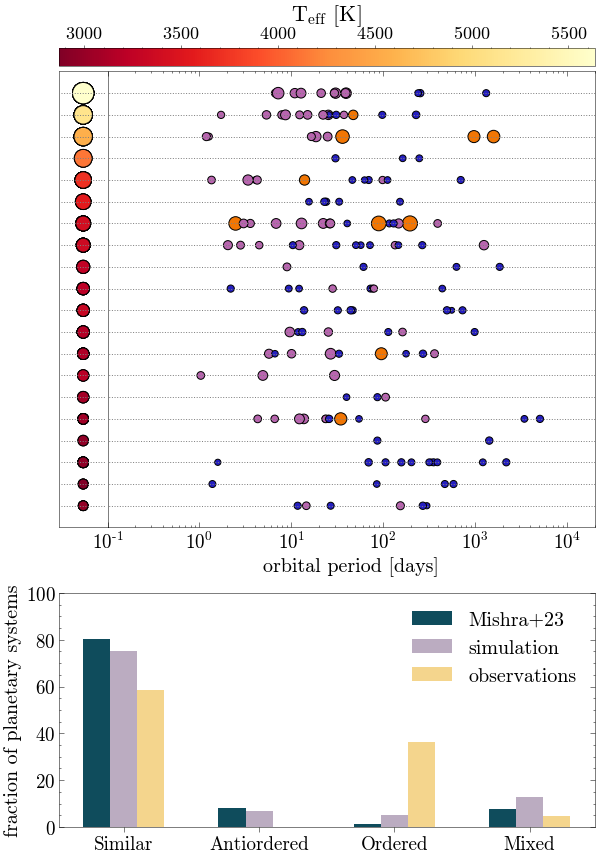

In [ ]:
# test for one system...
seed_rdm = 1999
random.seed(seed_rdm)
list_idhs = random.sample(list(sample_SN.planets.id_hoststar.unique()), 20)
sp_rdm = sample_SN.planets[sample_SN.planets.id_hoststar.isin(list_idhs)]

# sort values by stellar mass
sp = sp_rdm.sort_values(by='mass_star', inplace=False, ignore_index=True)

## assign them a new index to plot
sp['id_new'] = np.zeros(len(sp))

list_hs_ids_ordered = sp.id_hoststar.unique()
for i in range(len(list_hs_ids_ordered)):
    sp.loc[sp.id_hoststar == list_hs_ids_ordered[i], 'id_new'] = i

xmin = 0.01
xmax = 2e4
ymin = 7
ymax = 9

################
fig = plt.figure(figsize=(8, len(sp.id_hoststar.unique())*0.5 + 3))

gs1 = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.98, top=0.95, bottom=0.37,
                        wspace=0.0, width_ratios=[0.1, 1])
ax1 = fig.add_subplot(gs1[:, 0])
ax2 = fig.add_subplot(gs1[:, 1], sharey=ax1)

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.98, top=0.30, bottom=0.05)
ax3 = fig.add_subplot(gs2[0, 0])

ax1.hlines(0.5*np.array(range(len(list_idhs))), -0.5, 0.5, ls='dotted', color='grey')
ax2.hlines(0.5*np.array(range(len(list_idhs))), xmin, xmax, ls='dotted', color='grey')

# draw stars
cb_st = ax1.scatter(np.zeros(len(sp)), 0.5*sp.id_new, marker='o', s=sp.radius_star*500, 
            c=sp.teff_star, cmap='YlOrRd_r', edgecolors='k')

# determine planet type by mass instead of label...
color_pltype = np.where(sp.mass_planet < limM_Earth_to_SEnept, c_earth, 
                        np.where((sp.mass_planet >= limM_Earth_to_SEnept) & (sp.mass_planet < limM_SEnept_to_giants),c_SEn,c_giants))
ax2.scatter(sp.period_planet, 0.5*sp.id_new, s=np.sqrt(sp.radius_planet.astype(float))*50, c=color_pltype, edgecolors='k')

# colorbar for star color
cbar_stars = fig.colorbar(cb_st, ax=(ax1, ax2), location='top', pad=0.01, aspect=30)
cbar_stars.set_label(r'$\rm T_{\rm eff}$ [K]', fontsize=fs+2)
cbar_stars.ax.tick_params(labelsize=fs-2, which='both', direction='out')

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(-0.5, len(sp.id_hoststar.unique())*0.5)
ax2.set_xlabel('orbital period [days]', fontsize=fs)
ax2.tick_params(axis='x', which='major', labelsize=fs-1, length=5)
ax2.tick_params(axis='x', which='minor', labelsize=fs-1, length=2)
ax2.set_xscale('log')
ax2.set_xlim(0.1, 20000)

################### planetary systems architecture
x = np.arange(len(arch_types))
width = 0.2
multiplier = 0
for attribute, measurement in counts_normsttype.items():
    offset = width * multiplier
    rects_normsttype = ax3.bar(x + offset, measurement, width, label=attribute, color=dict_colors[attribute])
    multiplier += 1

ax3.set_ylabel('fraction of planetary systems', fontsize=fs)
ax3.set_xticks(x + width, arch_types, fontsize=fs)
ax3.tick_params(axis='x', which='major', labelsize=fs-1, length=5, direction='out', top=False)

ax3.tick_params(axis='x', which='minor', direction='out', top=False, bottom=False)
ax3.tick_params(axis='y', which='major', labelsize=fs-1, length=5)
ax3.tick_params(axis='y', which='minor', length=2)
ax3.set_ylim(0, 100)
ax3.legend(fontsize=fs)


#plt.savefig('./figures/planetary_syst_seed%s_AND_planetarysyst_architectures_25ago25.pdf'%(seed_rdm), bbox_inches='tight')
plt.show()

# Fig. B1: Host stars properties, Kepler field

In [9]:
####### exoplanets detected by Kepler
exopl_kepler = Table.read("data/plots_files/cumulative_2025_01_24_crossmatchSH.votable").to_pandas()
### take out False Positives
exopl_kepler = exopl_kepler[~(exopl_kepler['koi_disposition']=="FALSE POSITIVE")]
### delete empty lines (106)
exopl_kepler = exopl_kepler.dropna(subset=['koi_prad']).reset_index()

filter_confirmed = exopl_kepler['koi_disposition'] == 'CONFIRMED'
filter_candidate = exopl_kepler['koi_disposition'] == 'CANDIDATE'

print("all Kepler planets:", len(exopl_kepler))
print("confirmed:", len(exopl_kepler[filter_confirmed]))
print("candidates:", len(exopl_kepler[filter_candidate]))

exopl_kepler['insolation'] = UTILS.ComputeInsolation_obs(exopl_kepler['Rad']*u.R_sun.to(u.m), exopl_kepler['koi_sma'], exopl_kepler['koi_steff'])[1]

### st_kepler_pl: df with host stars of Kepler planets (one line per star)
exopl_kepler['kepoi_sname'] = ' '
for i in range(len(exopl_kepler)):
    exopl_kepler.loc[i, 'kepoi_sname'] = str(exopl_kepler.loc[i, 'kepoi_name'])[:-3]

print(len(exopl_kepler['kepoi_sname'].unique()))

st_kepler_pl = exopl_kepler.drop_duplicates(subset=['kepoi_sname'], keep='first')

all Kepler planets: 4619
confirmed: 2741
candidates: 1878
3528


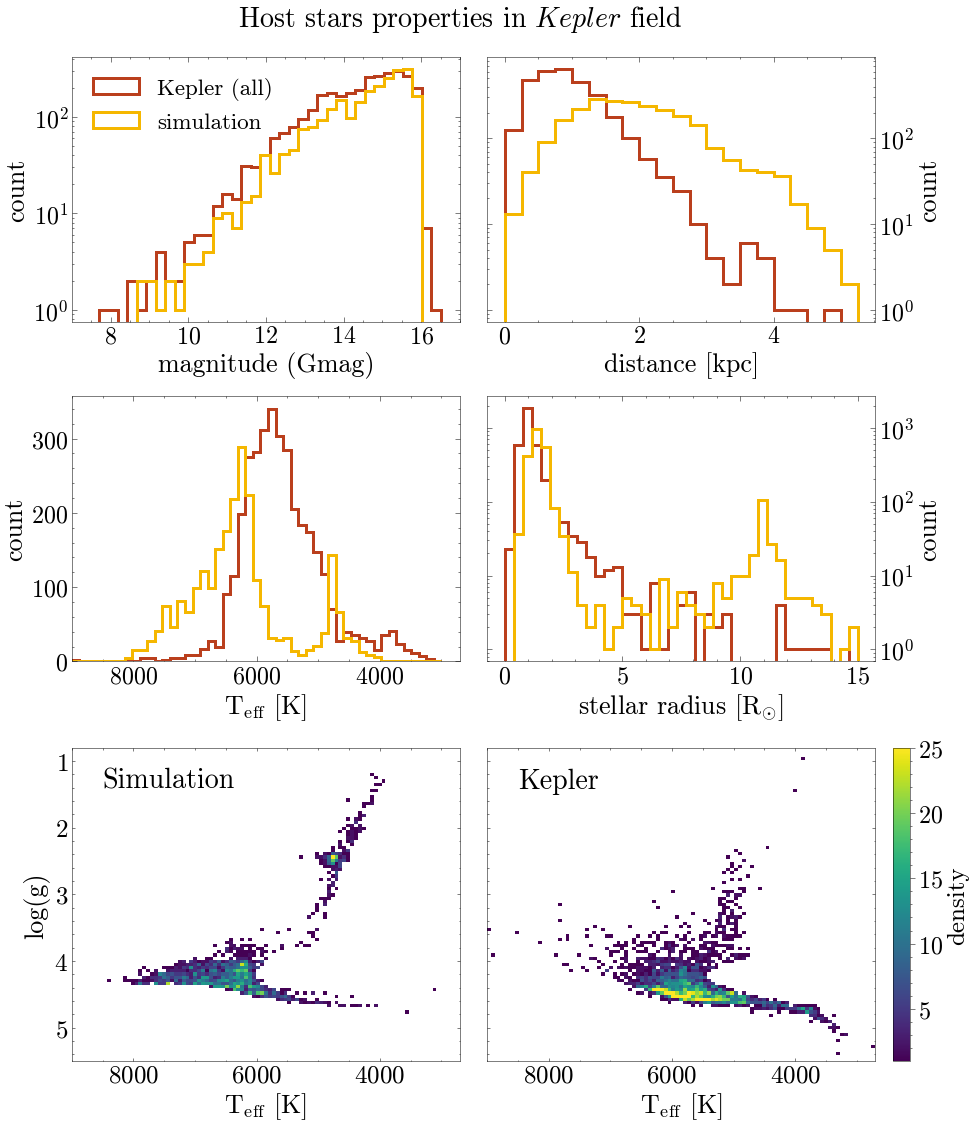

In [ ]:
bins_mag = np.linspace(5, 17, 50)
fs=26

color_Kepler = "#BA3F1D"
color_HS_det = "#F5B700"

fig = plt.figure(figsize=(12, 15))

gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.05, right=0.98, top=0.98, bottom=0.42,
                       wspace=0.07, hspace=0.28)
gs2 = fig.add_gridspec(nrows=1, ncols=2, left=0.05, right=0.98, top=0.34, bottom=0.05,
                       wspace=0.07)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[1, 0])
ax4 = fig.add_subplot(gs1[1, 1])

axl = fig.add_subplot(gs2[0, 0])
axr = fig.add_subplot(gs2[0, 1], sharex=axl, sharey=axl)

ax1.hist(st_kepler_pl['phot_g_mean_mag'], histtype='step', bins=bins_mag, lw=3, label='Kepler (all)', 
         density=False, color =color_Kepler)
ax1.hist(st_detect_pl['Gmag'], histtype='step', bins=bins_mag, lw=3, label='simulation', 
         density=False, color=color_HS_det)

ax2.hist(st_kepler_pl['Dist_1']/1000, histtype='step', bins=np.arange(0, 5.5, 0.250), lw=3, label='Kepler: '+str(len(st_kepler_pl))+' host stars', 
         density=False, color=color_Kepler)
ax2.hist(st_detect_pl['dist'], histtype='step', bins=np.arange(0, 5.5, 0.250), lw=3, label='simu: '+str(len(st_detect_pl))+' host stars', 
         density=False, color=color_HS_det)

ax3.hist(st_kepler_pl['koi_steff'], histtype='step', bins=np.linspace(3000, 9000, 50), lw=3, label='Kepler', 
         density=False, color=color_Kepler)
ax3.hist(st_detect_pl['teff'], histtype='step', bins=np.linspace(3000, 9000, 50), lw=3, label='simu', 
         density=False, color=color_HS_det)

ax4.hist(st_kepler_pl['koi_srad'], histtype='step', bins=np.linspace(0, 15, 40), lw=3, label='Kepler', 
         density=False, color=color_Kepler)
ax4.hist(st_detect_pl['R_star'], histtype='step', bins=np.linspace(0, 15, 40), lw=3, label='simu', 
         density=False, color=color_HS_det)

ax1.tick_params(axis='both', labelsize=fs-2, right=True, top=True, direction='in')
ax2.tick_params(axis='both', labelsize=fs-2, right=True, top=True, direction='in', labelright=True, labelleft=False)
ax3.tick_params(axis='both', labelsize=fs-2, right=True, top=True, direction='in')
ax4.tick_params(axis='both', labelsize=fs-2, right=True, top=True, direction='in', labelright=True, labelleft=False)

ax1.set_yscale('log')
ax1.set_xlim(7, 17)
ax2.set_yscale('log')
ax1.set_xlabel('magnitude (Gmag)', fontsize=fs)
ax2.set_xlabel('distance [kpc]', fontsize=fs)
ax1.set_ylabel('count', fontsize=fs)
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('count', fontsize=fs)
ax3.set_xlabel(r'$\rm T_{\rm eff}$ [K]', fontsize=fs)
ax3.set_ylabel('count', fontsize=fs)
ax4.yaxis.set_label_position('right')
ax4.set_ylabel('count', fontsize=fs)
ax3.set_xlim(2700, 9000)
ax4.set_xlabel(r'stellar radius [$\rm R_{\odot}$]', fontsize=fs)
ax4.set_yscale('log')
ax3.invert_xaxis()

ax1.tick_params(axis='both', which='major', length=5)
ax2.tick_params(axis='both', which='major', length=5)
ax3.tick_params(axis='both', which='major', length=5)
ax4.tick_params(axis='both', which='major', length=5)
ax1.tick_params(axis='both', which='minor', length=2)
ax2.tick_params(axis='both', which='minor', length=2)
ax3.tick_params(axis='both', which='minor', length=2)
ax4.tick_params(axis='both', which='minor', length=2)


ax1.legend(loc='upper left', fontsize=fs-3)
fig.suptitle("Host stars properties in $Kepler$ field", x=0.5, y=1.03, fontsize=fs+2)


###########################################

col1 = axl.hist2d(st_detect_pl['teff'], st_detect_pl['logg'], 
                  bins=(np.linspace(2700, 9000, 100), np.linspace(0.8, 5.5, 100)), 
                  cmin=0.1, vmax=25, rasterized=True)
col2 = axr.hist2d(st_kepler_pl['koi_steff'], st_kepler_pl['koi_slogg'], 
                  bins=(np.linspace(2700, 9000, 100), np.linspace(0.8, 5.5, 100)), 
                  cmin=0.1, vmax=25, rasterized=True)

[[x10,y10],[x11,y11]] = axr.get_position().get_points()
pad = 0.02; width = 0.02
cbar_ax = fig.add_axes([x11+pad, y10, width,(y11-y10)])
cbar_ax.yaxis.set_ticks_position('right')
cbar = fig.colorbar(col1[3], cax=cbar_ax)
cbar_ax.tick_params(labelsize=fs-2, which='both', direction='out')
cbar_ax.tick_params(which='major', length=5)
cbar_ax.tick_params(which='minor', length=2)
cbar.set_label('density', fontsize=fs-1)

axl.invert_xaxis()
axl.invert_yaxis()

axl.text(x=8500, y=1.4, s='Simulation', fontsize=fs+2)
axr.text(x=8500, y=1.4, s='Kepler', fontsize=fs+2)

axl.locator_params(axis='y', nbins=5) 
axl.tick_params(axis='both', labelsize=fs-1, right=True, top=True, direction='in')
axr.tick_params(axis='both', labelsize=fs-1, right=True, top=True, direction='in', labelleft=False)

axl.set_ylabel('log(g)', fontsize=fs)
axl.set_xlabel(r'$\rm T_{\rm eff}$ [K]', fontsize=fs)
axr.set_xlabel(r'$\rm T_{\rm eff}$ [K]', fontsize=fs)

#plt.savefig("./figures/comparison_stellar_param_HOSTSTARS_Kepler_vs_simu_kiel_14juliol25.pdf", bbox_inches='tight')
plt.show()

# Fig. B2: comparison transit depth/SNR estimation w/ Kepler

In [ ]:
####### exoplanets detected by Kepler
exopl_kepler = Table.read("./data/plots_files/cumulative_2025_01_24_crossmatchSH.votable").to_pandas()
### take out False Positives
exopl_kepler = exopl_kepler[~(exopl_kepler['koi_disposition']=="FALSE POSITIVE")]
### delete empty lines (106)
exopl_kepler = exopl_kepler.dropna(subset=['koi_prad']).reset_index()

filter_confirmed = exopl_kepler['koi_disposition'] == 'CONFIRMED'
filter_candidate = exopl_kepler['koi_disposition'] == 'CANDIDATE'

print("all Kepler planets:", len(exopl_kepler))
print("confirmed:", len(exopl_kepler[filter_confirmed]))
print("candidates:", len(exopl_kepler[filter_candidate]))

exopl_kepler = DETECTION_MODULE.compute_detection_nb_realKeplerPl(exopl_kepler)

all Kepler planets: 4619
confirmed: 2741
candidates: 1878
### Initial nb of planets: 4619
### nb with incl compatible with transit det: 3708
/home/chloe/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)

### computing transit depth
### assigning CDPP...
### computing nb of transits
### computing SNR..


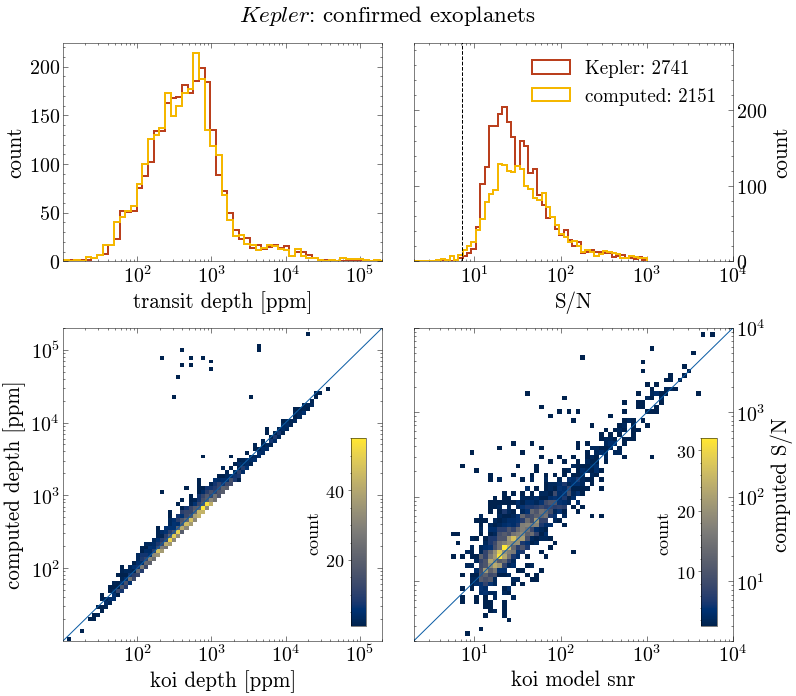

In [ ]:
fs = 21
color_Kepler = "#BA3F1D"
color_simu = "#F5B700"

trd_lim = [10.1, 2e5]
snr_lim = [2, 1e4]

exopl_kepler = exopl_kepler[filter_confirmed]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={'height_ratios': [0.7, 1]})
fig.subplots_adjust(hspace=0.25, wspace=0.1)
## histo transit depth
ax1.hist(exopl_kepler['koi_depth'], bins=np.logspace(1, 5.5, 60), histtype='step', label='koi depth', lw=2, color=color_Kepler)
ax1.hist(exopl_kepler['computed_depth'], bins=np.logspace(1, 5.5, 60), histtype='step', label='computed', lw=2, color=color_simu)

## histo SNR
ax2.hist(exopl_kepler['koi_model_snr'], bins=np.logspace(0, 3, 60), histtype='step', color=color_Kepler,
         label='Kepler: '+str(len(exopl_kepler[exopl_kepler['koi_model_snr']>0])), lw=2, density=False)
ax2.hist(exopl_kepler['SNR'], bins=np.logspace(0, 3, 60), histtype='step', color=color_simu,
         label='computed: '+str(len(exopl_kepler[exopl_kepler['SNR']>0])), lw=2, density=False)

ax2.vlines(7.1, 0, 350, colors='k', ls='--')

### compare transit depth
col3 = ax3.hist2d(exopl_kepler['koi_depth'].values, exopl_kepler['computed_depth'].values, 
           bins=(np.logspace(np.log10(trd_lim[0]), np.log10(trd_lim[1]), 80), 
                 np.logspace(np.log10(trd_lim[0]), np.log10(trd_lim[1]), 80)), cmin=1, cmap='cividis',
                 rasterized=True)
ax3.plot(np.logspace(0, 6), np.logspace(0, 6))

### compare SNR
col4 = ax4.hist2d(exopl_kepler['koi_model_snr'].values, exopl_kepler['SNR'].values, 
           bins=(np.logspace(np.log10(snr_lim[0]), np.log10(snr_lim[1]), 70), 
                 np.logspace(np.log10(snr_lim[0]), np.log10(snr_lim[1]), 70)), cmin=1, cmap='cividis',
                 rasterized=True)
ax4.plot(np.logspace(0, 4, 50), np.logspace(0, 4, 50))


####### axes
ax1.set_xscale('log')
ax1.set_xlabel('transit depth [ppm]', fontsize=fs)
ax1.set_ylabel('count', fontsize=fs)
ax1.set_xlim(0.2, 1e6)
#ax1.legend(loc='upper left', fontsize=fs-2)

#ax2.set_xlim(1, 1e3)
ax1.set_xlim(trd_lim[0], trd_lim[1])
ax2.set_xlim(snr_lim[0], snr_lim[1])

ax2.set_ylim(0, 290)
ax2.set_xscale('log')
ax2.set_xlabel('S/N', fontsize=fs)
ax2.set_ylabel('count', fontsize=fs)
ax2.legend(fontsize=fs-2)
ax2.tick_params(labelright=True, labelleft=False)
ax2.yaxis.set_label_position("right")

ax3.set_xlabel('koi depth [ppm]', fontsize=fs)
ax3.set_ylabel('computed depth [ppm]', fontsize=fs)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(trd_lim[0], trd_lim[1])
ax3.set_ylim(trd_lim[0], trd_lim[1])

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('koi model snr', fontsize=fs)
ax4.set_ylabel('computed S/N', fontsize=fs, )
ax4.tick_params(labelright=True, labelleft=False)
ax4.yaxis.set_label_position("right")

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='both', which='major', labelsize=fs-1, length=5)
    ax.tick_params(axis='both', which='minor', length=2)

[[xa0,ya0],[xa1,ya1]] = ax3.get_position().get_points()
[[xb0,yb0],[xb1,yb1]] = ax4.get_position().get_points()
pad = (xa1-xa0)*0.05; width = 0.018
cbar_ax1 = fig.add_axes([xa1-(pad+width), ya0+pad, width, (ya1-ya0)*0.6])
cbar_ax2 = fig.add_axes([xb1-(pad+width), yb0+pad, width, (yb1-yb0)*0.6])

cbar1 = fig.colorbar(col3[3], cax=cbar_ax1)#, location='top', pad=0.02)
cbar2 = fig.colorbar(col4[3], cax=cbar_ax2)#, location='top', pad=0.02)
cbar_ax1.tick_params(labelsize=fs-3, which='both', direction='out')#, left=True, right=False, labelleft=True, labelright=False)
cbar_ax2.tick_params(labelsize=fs-3, which='both', direction='out')#, left=True, right=False, labelleft=True, labelright=False)

cbar_ax1.yaxis.set_ticks_position('left')
cbar_ax2.yaxis.set_ticks_position('left')
cbar_ax1.yaxis.set_label_position('left')
cbar_ax2.yaxis.set_label_position('left')
cbar1.set_label('count', fontsize=fs-3)
cbar2.set_label('count', fontsize=fs-3)

fig.suptitle("$Kepler$: confirmed exoplanets", fontsize=fs+2, y=0.93)

#plt.savefig("./figures/comparison_tr-depth_SNR_Kepler-koi_vs_simu_14juliol25.pdf", bbox_inches='tight')
plt.show()